# the script implemented in a notebook to look at whats happening

In [6]:

# import stuff
import sys,os,os.path
import csv
import traceback
#sys.path.append("../../")   # cite IC from parent directory
sys.path.append("/scratch/halmazan/NEXT/IC_alter-blob-centre/")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
sys.path.append("/scratch/halmazan/NEXT/testing/notebooks/FOM_creator/")
os.environ['ICTDIR']='/scratch/halmazan/NEXT/IC_alter-blob-centre/'

from invisible_cities.core.core_functions   import shift_to_bin_centers
from invisible_cities.io.dst_io           import load_dst, load_dsts, df_writer

import FOM_functions as FOM_func
import functions_HE as func
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd





import scipy.special as special
from scipy.stats import norm
from scipy.stats import skewnorm, crystalball
from scipy.optimize import curve_fit
from tqdm import tqdm

from scipy.integrate import quad

import iminuit
from iminuit import Minuit
import probfit
from concurrent.futures import ProcessPoolExecutor

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tables as tb
from matplotlib import colors 

from typing          import Optional
from typing          import Union
from typing          import Callable

from concurrent.futures import ProcessPoolExecutor

import sys,os,os.path
from pathlib import Path

from invisible_cities.io.dst_io           import load_dst, load_dsts, df_writer
from invisible_cities.io.hits_io          import hits_writer
from invisible_cities.core                import tbl_functions   as tbl
from invisible_cities.core.core_functions import in_range
#from invisible_cities.cities.beersheba    import hitc_to_df_
from invisible_cities.io.hits_io          import hits_from_df
from invisible_cities.evm.nh5             import HitsTable
from invisible_cities.types.symbols       import NormStrategy
from invisible_cities.types.ic_types      import NoneType
from invisible_cities.reco.corrections    import read_maps, get_df_to_z_converter, apply_all_correction
from invisible_cities.evm.event_model     import HitCollection

from tqdm import tqdm


def load_single_file(file_path):
    '''
    Load data from a single h5 file and produce dataframes for /Tracking/Tracks

    Args:
        file_path       :       str
                                Path to the h5 file to be loaded.

    Returns:
        tracks_df       :       pandas.DataFrame
                                DataFrame containing the /Tracking/Tracks data.
    '''
    try: 
        tracks_df = load_dst(file_path, 'Tracking', 'Tracks')
        return tracks_df
    except Exception as e:
        print(f'File {file_path} broke with error:\n{e}', flush = True)
        x = pd.DataFrame()
        return x

## FUNCTIONS ##

def load_data_fast(folder_path):
    '''
    Load multiple h5 files and produce concatenated dataframes for /Tracking/Tracks, /MC/Particles, and their corresponding eventmap.

    Args:
        folder_path     :       str
                                Path to the folder containing the h5 files.

    Returns:
        tracks          :       pandas.DataFrame
                                Concatenated DataFrame containing the /Tracking/Tracks data from all h5 files.
        
        particles       :       pandas.DataFrame
                                Concatenated DataFrame containing the /MC/particles data from all h5 files, with the 'event_id' column modified.

        eventmap        :       pandas.DataFrame
                                Concatenated DataFrame containing the event map from all h5 files.
    '''
    
    file_names = [f for f in os.listdir(folder_path) if f.endswith('.h5')]
    file_paths = [os.path.join(folder_path, f) for f in file_names]

    # Use ProcessPoolExecutor to parallelize the data loading process
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(load_single_file, file_paths))
    
    # Separate the results into respective lists
    tracks_list = results

    # Concatenate all the dataframes at once
    tracks = pd.concat(tracks_list, axis=0, ignore_index=True)

    return tracks


def load_data(pth):
    hdst = []

    for i in tqdm(range(1,8)):
        print(f"LDC {i}", flush = True)
        flder_pth = pth + 'ldc' + str(i) + '/'
        hdst.append(load_data_fast(flder_pth))

    hdst = pd.concat(hdst)
    return hdst



def main(RUN_NUMBER, 
         TIMESTAMP, 
         CITY,
         FOM_TS):
    
    print('=' * 20, flush = True)
    print(f'RUNS: {RUN_NUMBER}\nTIMESTAMPS: {TIMESTAMP}', flush = True)
    print('=' * 20, flush = True)




    # make directory
    pre_dir = '/scratch/halmazan/NEXT/PROCESSING/FOM/data/'
    folder_name = f'{pre_dir}/{FOM_TS}'
    folder_s = Path(f'{folder_name}')
    folder_s.mkdir(parents=True, exist_ok=True)


    # load
    hdst_local = []
    for RN, TS in zip(RUN_NUMBER, TIMESTAMP):
        print(f'R{RN}: {TS}', flush = True)
        n100_dir = f'/scratch/halmazan/NEXT/PROCESSING/topology_cuts/data/{RN}/{TS}/'
        hdst_local.append(pd.read_hdf(f'{n100_dir}cut_hdst.h5'))
        print(f'Loaded!', flush = True)
    hdst = pd.concat(hdst_local)
 

    # quick plot for sanity reasons.
    plt.hist(hdst.energy, bins = 100)
    plt.title(f"FULL DATASET ENERGY DISTRIBUTION")
    plt.xlabel("Energy (MeV)")
    plt.ylabel("Counts")
    plt.savefig(f'{folder_name}/hist_plot.pdf')
    plt.close()

    vars = 'energy'
    labels = '(MeV)'
    log_flag = False
    print('=' * 20, flush = True)
    print('data loaded', flush = True)

    # DEFINING ALL THE FUNCTIONS INSIDE CAUSE IM SCARED

    #def sig_func(x, ns, beta, m, loc, scale):
    #    '''
    #    signal function now defined by a crystal ball
    #    Args:
    #        x       : numpy.ndarray
    #                  Independent variable (e.g., energy values).
    #        ns      : float
    #                  Normalization factor for the signal component.
    #        B       : float
    #                  Background parameter  related to the exponential decay.
    #        M       : float
    #                  Mean value of the crystal ball distribution, representing the peak position.
    #    Returns:
    #        numpy.ndarray
    #        The evaluated signal function values for the given input parameters.
    #    '''

    #    return ns * (crystalball.pdf(x, beta, m, loc = loc, scale = scale))

    def sig_func(x, ns, loc, scale):
        '''
        signal function now defined by a crystal ball
        Args:
            x       : numpy.ndarray
                      Independent variable (e.g., energy values).
            ns      : float
                      Normalization factor for the signal component.
            
        Returns:
            numpy.ndarray
            The evaluated signal function values for the given input parameters.
        '''

        return ns * (norm.pdf(x, loc = loc, scale = scale))


    def sig_func_no_N(x, loc, scale):
        '''
        signal function now defined by a crystal ball
        Args:
            x       : numpy.ndarray
                      Independent variable (e.g., energy values).
            B       : float
                      Background parameter  related to the exponential decay.
            M       : float
                      Mean value of the crystal ball distribution, representing the peak position.
        Returns:
            numpy.ndarray
            The evaluated signal function values for the given input parameters.
        '''

        return (norm.pdf(x, loc = loc, scale = scale))



#    def sig_func_no_N(x, B, M, loc, scale):
#        '''
#        signal function now defined by a crystal ball
#        Args:
#            x       : numpy.ndarray
#                      Independent variable (e.g., energy values).
#            B       : float
#                      Background parameter  related to the exponential decay.
#            M       : float
#                      Mean value of the crystal ball distribution, representing the peak position.
#        Returns:
#            numpy.ndarray
#            The evaluated signal function values for the given input parameters.
#        '''
#
#        return (crystalball.pdf(x, B, M, loc = loc, scale = scale))

#    def sig_bck_func(x, ns, nb, B, M, tau, loc, scale):
#        return (sig_func(x, ns, B, M, loc, scale) + FOM_func.bck_func(x, nb, tau))

    def sig_bck_func(x, ns, nb, tau, loc, scale):
        return (sig_func(x, ns, loc, scale) + FOM_func.bck_func(x, nb, tau))



    def add_element(dict, key, value):
        if key not in dict:
            dict[key] = value

    def gaussian_fit_stupid(data, binning=80, plot=False):
        '''
        Function that fits using curve_fit the data with the respected binning
        '''
        blob_np = data['energy'].to_numpy()
        # Create histogram
        heights, bins = np.histogram(blob_np, bins=binning)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        # Define Gaussian function
        def gaussian(x, a, mu, sigma):
            return a * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
        # Initial guess for curve_fit
        initial_guess = [heights.max(), bin_centers[np.argmax(heights)], np.std(blob_np)]
        # Fit the histogram data
        try:
            popt, pcov = curve_fit(gaussian, bin_centers, heights, p0=initial_guess)
        except RuntimeError as e:
            print(f"Curve fitting failed: {e}")
            return None, None
        if plot:
            # Plot the histogram and the fitted Gaussian
            plt.hist(blob_np, bins=binning, alpha=0.6, label="Data")
            x_fit = np.linspace(bin_centers.min(), bin_centers.max(), 1000)
            plt.plot(x_fit, gaussian(x_fit, *popt), label="Gaussian Fit", color="red")
            plt.xlabel("Energy (MeV)")
            plt.ylabel("Counts")
            plt.legend()
            plt.show()
        # Return the mean (mu) and standard deviation (sigma)
        return popt[1], popt[2]
    
    
    def gaussian_fit(data, binning = 80, plot = False):
        '''
        Fit gaussian to the data
        '''
        blob_np = data['energy'].to_numpy()

        # produce gaussian fit
        lh_g = probfit.UnbinnedLH(gauss_norm_ext_, blob_np, extended = True)
        vals_g = [len(blob_np), 1.59, 0.004]
        nm_g = ['Ng', 'mu', 'sigma']

        m_g = Minuit(lh_g, **dict(zip(nm_g, vals_g)), 
                    limit_mu=(1.58, 1.60), limit_Ng=(0,None), limit_sigma=(0,5))
        m_g.print_level = 1  # Set verbosity level to show progress during minimization
        print("Starting minimization with migrad...", flush = True)
        # minimise it
        m_g.migrad()


        if (plot == True):
            # plot output
            try:
                plt.clf()
            except Exception as e:
                print(f'Couldnt clear plot:\n{e}')
            #heights, bins, _ = plt.hist(blob_np, binning)
            plt.xlabel("Track energy (MeV)")
            plt.ylabel("Counts/bin")
            lh_g.show(parts=True)
            plt.show()

        # pull out the relevant values
        fit_params = {}
        [add_element(fit_params, m_g.params[i][1],m_g.params[i][2]) for i in range(len(m_g.params))]
        mu = fit_params['mu']
        sigma = fit_params['sigma']


        return (mu, sigma)

    def sb_fit(data, mu, sigma, fit_bins, plot = False, folder_input = ''):
        '''
        Fit signal and background to data
        '''
        blob_np = data['energy'].to_numpy()
        # create signal background pdf
        pdf_sb = probfit.AddPdf(sig_norm_ext, bck_norm_ext)

        lh_sb = probfit.BinnedLH(pdf_sb, blob_np, bins = len(fit_bins)-1, extended = True)

        y, x = np.histogram(blob_np, fit_bins)
        x = shift_to_bin_centers(x)

        # give it rough starting spots
        ###vals_sb = [len(blob_np)/2, len(blob_np)/2, 1, 1.1, 0.9, mu, sigma]
        ###nm_sb = ['Ns', 'Nb', 'B', 'M', 'tau', 'loc', 'scale']

        vals_sb = [len(blob_np)/2, len(blob_np)/2, 0.001, mu, sigma]
        nm_sb = ['Ns', 'Nb', 'tau', 'loc', 'scale']


        print('Initial guess:', flush = True)
        FOM_func.print_parameters(vals_sb, list(np.diag(np.zeros_like(vals_sb))), nm_sb)
        #FOM_func.plot_fit(sig_bck_func, np.linspace(data['energy'].min(), data['energy'].max(), 1000), vals_sb, nm_sb, output=True)


        #m_sb = Minuit(lh_sb, **dict(zip(nm_sb, vals_sb)), 
        #              limit_B = (0, 2),
        #              limit_M = (1, None),
        #              fix_loc = True,
        #              fix_scale = True,
        #              limit_tau=(0.1,None),
        #              print_level = 2)
        m_sb = Minuit(lh_sb, **dict(zip(nm_sb, vals_sb)), 
                      #fix_loc = True,
                      #fix_scale = True,
                      limit_loc = (1.57, 1.62),
                      #limit_tau=(0.0000001,None),
                      print_level = 2)

        print('Scan and then fit', flush = True)
        # minimise that mfer

        m_sb.migrad()

        if (plot == True):
            # plot output
            #heights, bins, _ = plt.hist(blob_np, binning)
            plt.xlabel("Track energy (MeV)")
            plt.ylabel("Counts/bin")
            lh_sb.show(parts=True)
            plt.savefig(f'{folder_input}')
            plt.show()

        # pull out the relevant values
        fit_params = {}
        [add_element(fit_params, m_sb.params[i][1],m_sb.params[i][2]) for i in range(len(m_sb.params))]

        return (fit_params['Ns'], fit_params['Nb'])


    def sb_fit_curve_fit(data, mu, sigma, fit_bins, plot=False, folder_input=''):
        '''
        Fit signal and background to data using curve_fit
        '''
        blob_np = data['energy'].to_numpy()
        y, x = np.histogram(blob_np, fit_bins)
        x = shift_to_bin_centers(x)
        # Define the combined signal and background function
        def combined_func(x, ns, nb, tau, loc, scale):
            signal = ns * norm.pdf(x, loc=loc, scale=scale)
            background = nb * np.exp(-tau * x)
            return signal + background
        # Initial guess for the parameters
        initial_guess = [len(blob_np) / 2, len(blob_np) / 2, 0.001, mu, sigma]
        try:
            # Perform the curve fitting
            popt, pcov = curve_fit(combined_func, x, y, p0=initial_guess)
        except RuntimeError as e:
            print(f"Curve fitting failed: {e}")
            return None, None
        if plot:
            # Plot the histogram and the fitted function
            plt.hist(blob_np, bins=fit_bins, alpha=0.6, label="data")
            x_fit = np.linspace(x.min(), x.max(), 1000)
            plt.plot(x_fit, combined_func(x_fit, *popt), label="fit", color="red")
            plt.xlabel("Energy (MeV)")
            plt.ylabel("Counts")
            plt.legend()
            plt.savefig(f'{folder_input}')
            plt.show()
        # Extract the fitted parameters
        ns, nb, tau, loc, scale = popt
        # extract the true number of counts for each fit wrt total counts in the data


        # Calculate the area under the signal function
        signal_area, _ = quad(lambda x: ns * norm.pdf(x, loc=loc, scale=scale), fit_bins[0], fit_bins[-1])
        # Calculate the area under the background function
        background_area, _ = quad(lambda x: nb * np.exp(-tau * x), fit_bins[0], fit_bins[-1])

        # Divide the areas by the bin width
        bin_width = fit_bins[1] - fit_bins[0]
        signal_area /= bin_width
        background_area /= bin_width


        return signal_area, background_area



    binning = 150
    cut_list = np.linspace(0,0.5, 31) # normally 51 not 5
    fit_range = [hdst.energy.min(), hdst.energy.max()]



    # normalise and extend
    sig_norm = probfit.Normalized(sig_func_no_N, fit_range)
    sig_norm_ext = probfit.Extended(sig_norm, extname = 'Ns')

    bck_norm = probfit.Normalized(FOM_func.bck_func_no_N, fit_range)
    bck_norm_ext = probfit.Extended(bck_norm, extname = 'Nb')

    gauss_norm = probfit.Normalized(FOM_func.gauss_no_N, fit_range)
    gauss_norm_ext_ = probfit.Extended(gauss_norm, extname = 'Ng')

    # create list for fom values
    e       = []
    b       = []
    ns_l      = []
    nb_l      = []
    fom     = []
    fom_err = []
    e_err = []
    b_err = []




    # apriori
    print('Starting the process...', flush = True)
    # [500, 1.65, 0.01]
    blob_data_fresh = hdst.copy(deep = True)
    func.plot_hist(blob_data_fresh, binning = binning, output = True, log = False)

    #gauss_hdst = func.energy_cuts(blob_data_fresh, 1.57, 1.615)
    func.plot_hist(blob_data_fresh, binning = binning, output = True, log = False, title = 'Gauss fit bins')
    # fit gaussian for mu and sigma    
    holder = gaussian_fit_stupid(blob_data_fresh)
    #holder = gaussian_fit(gauss_hdst, plot = True)
    mu = holder[0]
    sigma = holder[1]
    print(f'Gaussian fixed at:\nmu: {mu}\nsigma: {sigma}', flush = True)


    for i in range(len(cut_list)):
        # generate data
        try:
            blob_data = blob_data_fresh[(blob_data_fresh['eblob2'] > cut_list[i])]
            print("", flush = True)
            print("", flush = True)
            print("====================================", flush = True)
            print("Blob cut: {} MeV".format(cut_list[i]), flush = True)
            print("====================================", flush = True)

            plt.hist(blob_data.energy, bins = 100)
            plt.show()

            fit_bins = np.linspace(fit_range[0], fit_range[1], binning + 1)
            #holder_sb = sb_fit(blob_data, mu, sigma, fit_bins, plot = True, folder_input=f'{folder_name}/cut_{cut_list[i]}_fit.png')
            holder_sb = sb_fit_curve_fit(blob_data, mu, sigma, fit_bins, plot = True, folder_input=f'{folder_name}/cut_{cut_list[i]}_fit.png')
            

            ns_l.append(holder_sb[0])
            nb_l.append(holder_sb[1])

            print("Signal events: {}\nBackground events: {}\nTotal Events by addition: {}\nTotal Events by row counting: {}".format(ns_l[i], nb_l[i],nb_l[i] + ns_l[i], len(blob_data.index)), flush = True)

            # efficiency and background rej
            e_check = ns_l[i]/ns_l[0]
            b_check = nb_l[i]/nb_l[0]
            fom_check = e_check/np.sqrt(b_check)

            e.append(e_check)
            b.append(b_check)
            fom.append(fom_check)

                # errors for fom
            e_err.append(FOM_func.ratio_error(e[i],ns_l[i],ns_l[0],np.sqrt(ns_l[i]),np.sqrt(ns_l[0])))
            b_err.append(FOM_func.ratio_error(b[i],nb_l[i],nb_l[0],np.sqrt(nb_l[i]),np.sqrt(nb_l[0])))
            fom_err.append(FOM_func.fom_error(e[i], b[i], e_err[i], b_err[i]))
            
            print(f'FOM: {fom}\nfom_err: {fom_err}', flush = True)
            print(f'ns_l: {ns_l}\nnb_l: {nb_l}', flush = True)
            del blob_data, holder_sb

            print("====================================", flush = True)

        except Exception as ex:
            print(f'Yo shit broke!\n{ex}', flush = True)
            print(traceback.format_exc())
            ns_l.append(-9999)
            nb_l.append(-9999)
            e.append(-9999)
            b.append(-9999)
            fom.append(-9999)
            e_err.append(-9999)
            b_err.append(-9999)
            fom_err.append(-9999)
            try:
                del blob_data, holder_sb
            except:
                print('Cant delete shit that doesnt exist i guess?', flush = True)

    print(f'FOM:\n{fom}', flush = True)
    print(f'Cut list:\n{cut_list}', flush = True)
    try:
        plt.show()
    except Exception as e:
        print(e, flush = True)
    plt.errorbar(cut_list, fom, yerr = fom_err, label = 'FIT', linestyle = 'dashed')
    plt.legend()
    plt.title(f"FOM LPR R{FOM_TS}")
    plt.xlabel("Blob-2 energy threshold (MeV)")
    plt.xlim([0,0.55])
    #plt.ylim([0,2])
    plt.ylabel("fom")
    plt.savefig(f'{folder_name}/FOM_plot.pdf')
    plt.show()
    plt.close()

    # save
    with open(f'{folder_name}/FOM.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerows(zip(cut_list, fom))
        writer.writerows(zip(cut_list, fom_err))
        writer.writerows(zip(ns_l, nb_l))
        writer.writerows(zip(e,e_err))
        writer.writerows(zip(b,b_err))







RUNS: [15589, 15590, 15591, 15592, 15593, 15594, 15596]
TIMESTAMPS: [110725, 120725, 130725, 140725, 150725, 160725, 170725]
R15589: 110725
Loaded!
R15590: 120725
Loaded!
R15591: 130725
Loaded!
R15592: 140725
Loaded!
R15593: 150725
Loaded!
R15594: 160725
Loaded!
R15596: 170725
Loaded!
data loaded
Starting the process...


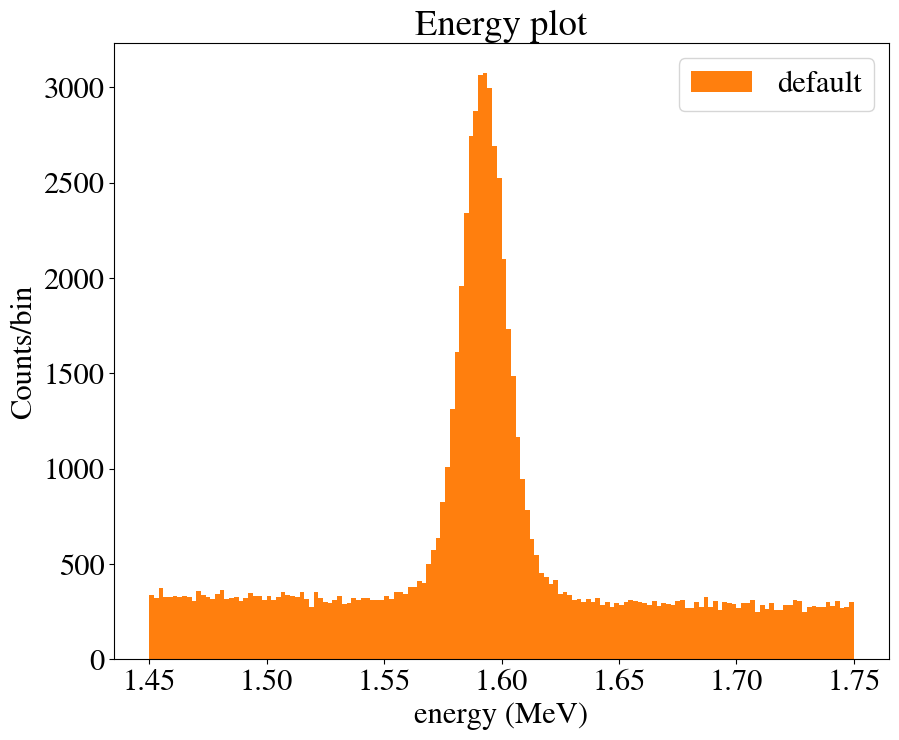

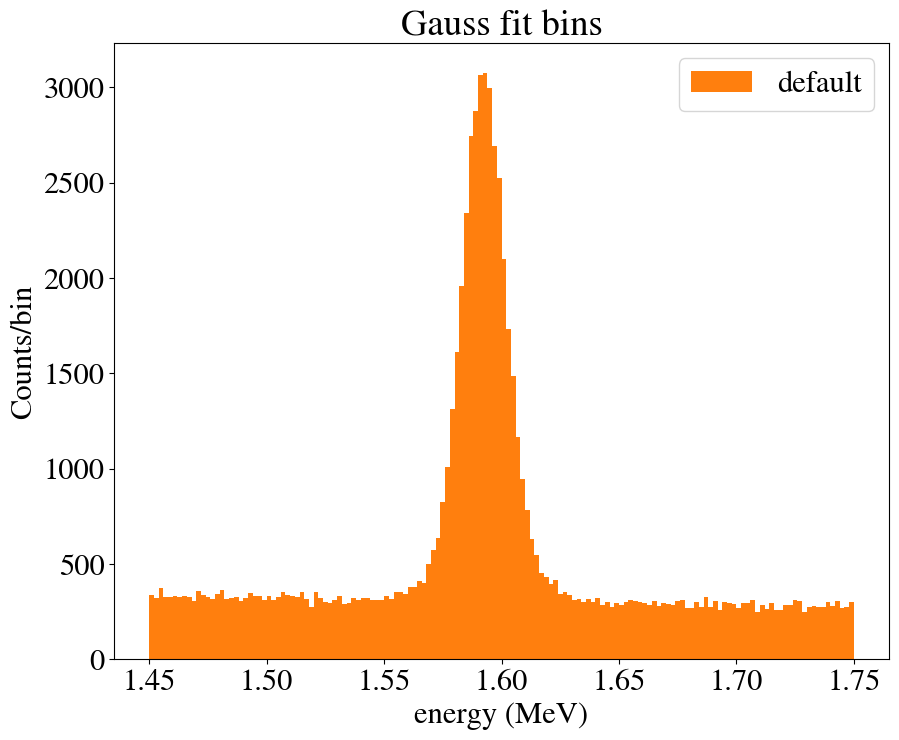

Gaussian fixed at:
mu: 1.592491558941475
sigma: 0.011636101305267743


Blob cut: 0.0 MeV


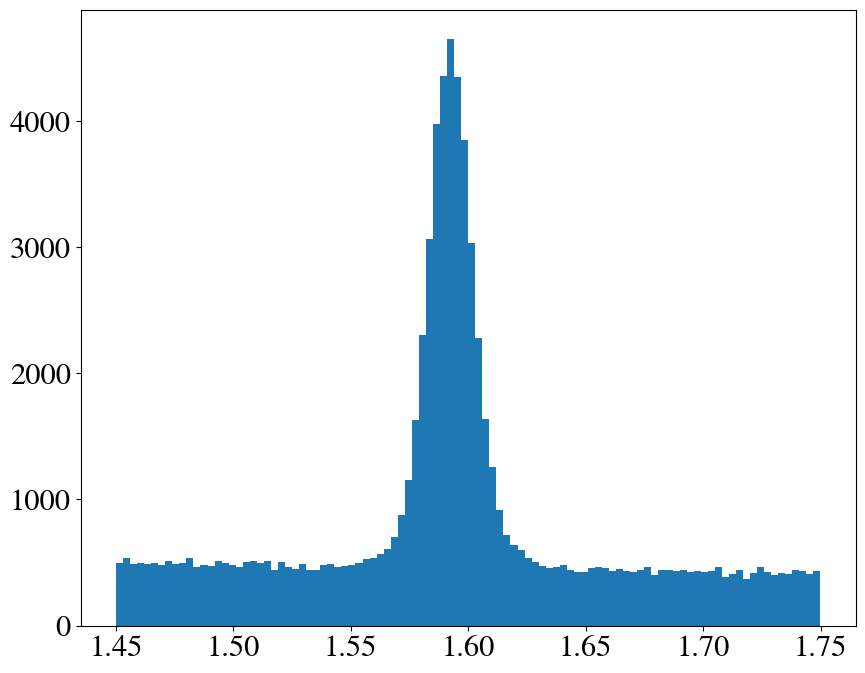

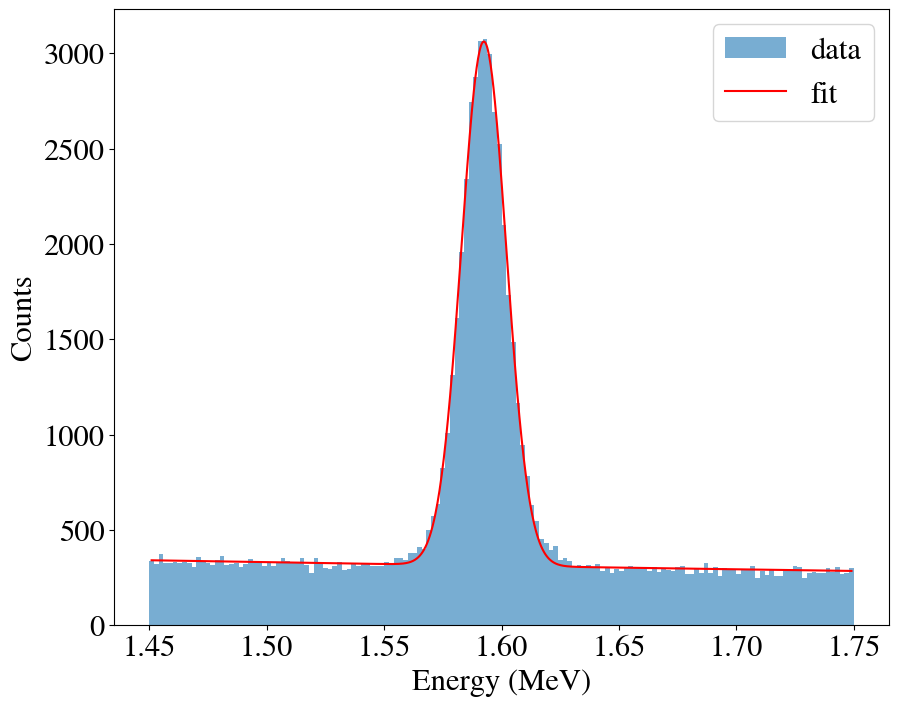

Signal events: 32919.38102949515
Background events: 46759.69755625128
Total Events by addition: 79679.07858574644
Total Events by row counting: 79678
FOM: [1.0]
fom_err: [0.00845265951237657]
ns_l: [32919.38102949515]
nb_l: [46759.69755625128]


Blob cut: 0.016666666666666666 MeV


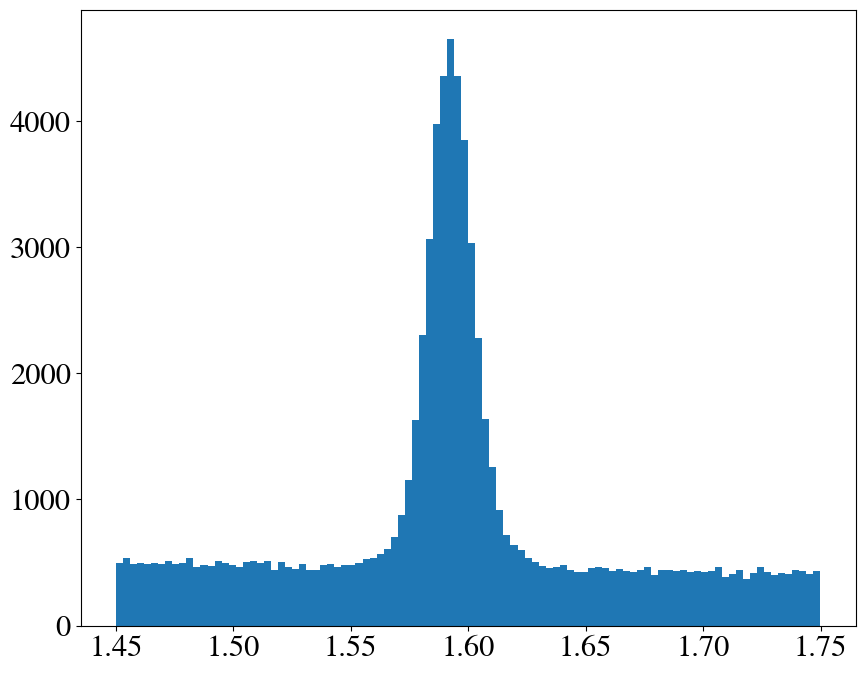

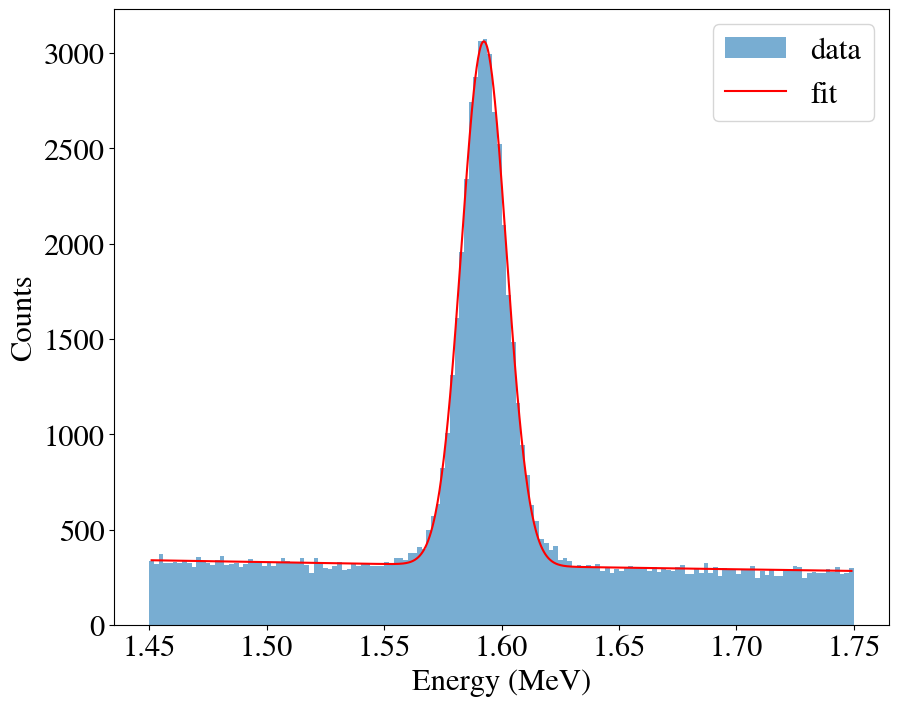

Signal events: 32918.97684386353
Background events: 46758.10450524169
Total Events by addition: 79677.08134910522
Total Events by row counting: 79676
FOM: [1.0, 1.0000047566266037]
fom_err: [0.00845265951237657, 0.008452732556368497]
ns_l: [32919.38102949515, 32918.97684386353]
nb_l: [46759.69755625128, 46758.10450524169]


Blob cut: 0.03333333333333333 MeV


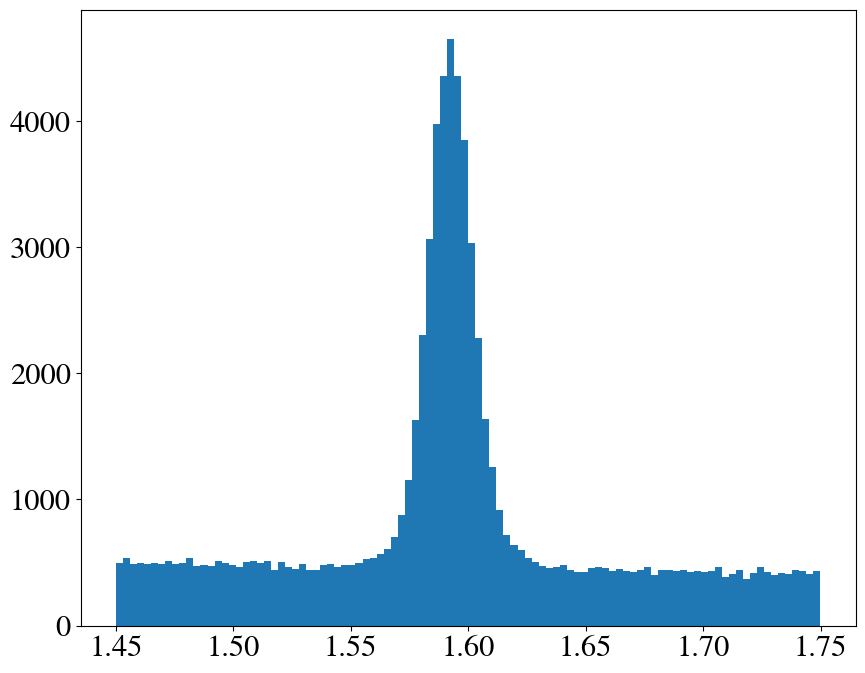

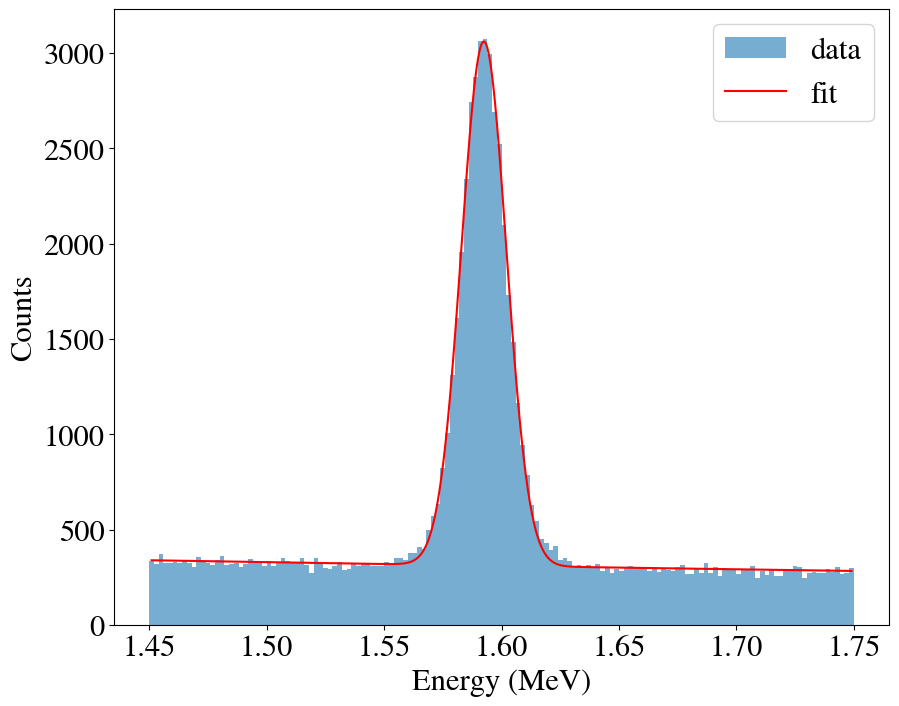

Signal events: 32914.6115301814
Background events: 46745.46573672096
Total Events by addition: 79660.07726690236
Total Events by row counting: 79659
FOM: [1.0, 1.0000047566266037, 1.000007308865403]
fom_err: [0.00845265951237657, 0.008452732556368497, 0.008453077954256894]
ns_l: [32919.38102949515, 32918.97684386353, 32914.6115301814]
nb_l: [46759.69755625128, 46758.10450524169, 46745.46573672096]


Blob cut: 0.05 MeV


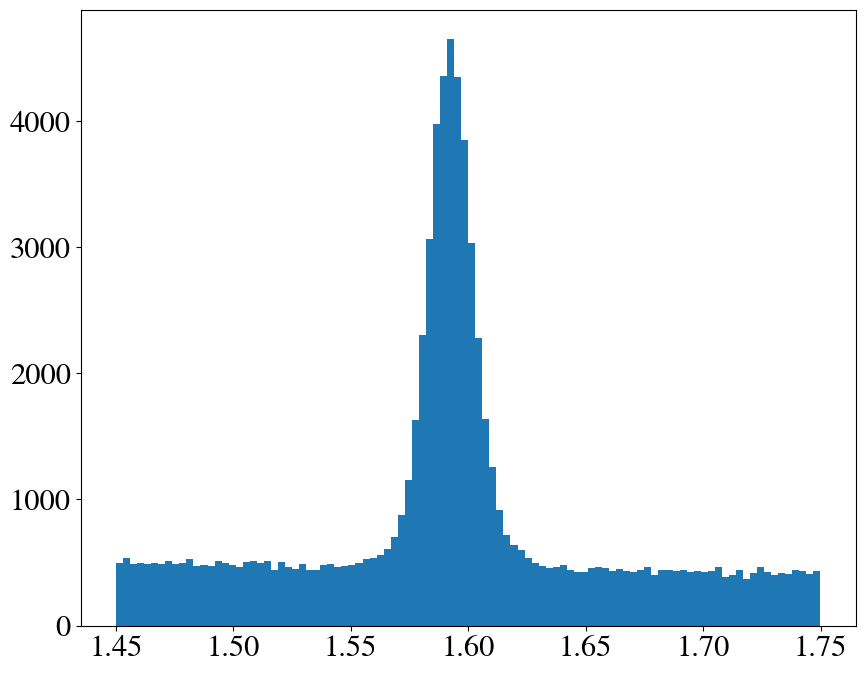

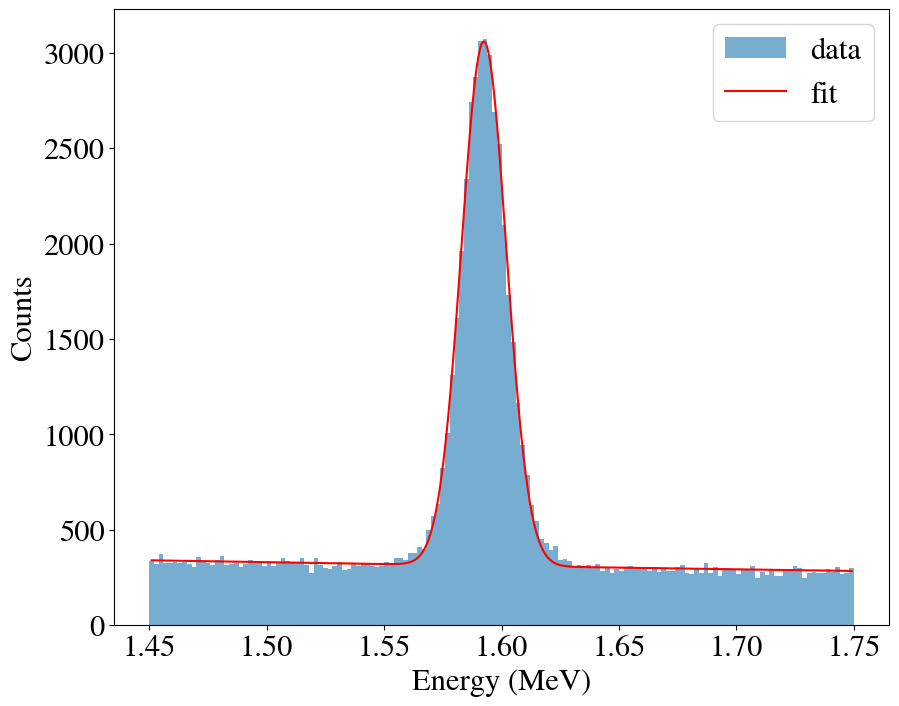

Signal events: 32899.766980129556
Background events: 46709.309865882096
Total Events by addition: 79609.07684601165
Total Events by row counting: 79608
FOM: [1.0, 1.0000047566266037, 1.000007308865403, 0.9999430878487394]
fom_err: [0.00845265951237657, 0.008452732556368497, 0.008453077954256894, 0.008453590692284142]
ns_l: [32919.38102949515, 32918.97684386353, 32914.6115301814, 32899.766980129556]
nb_l: [46759.69755625128, 46758.10450524169, 46745.46573672096, 46709.309865882096]


Blob cut: 0.06666666666666667 MeV


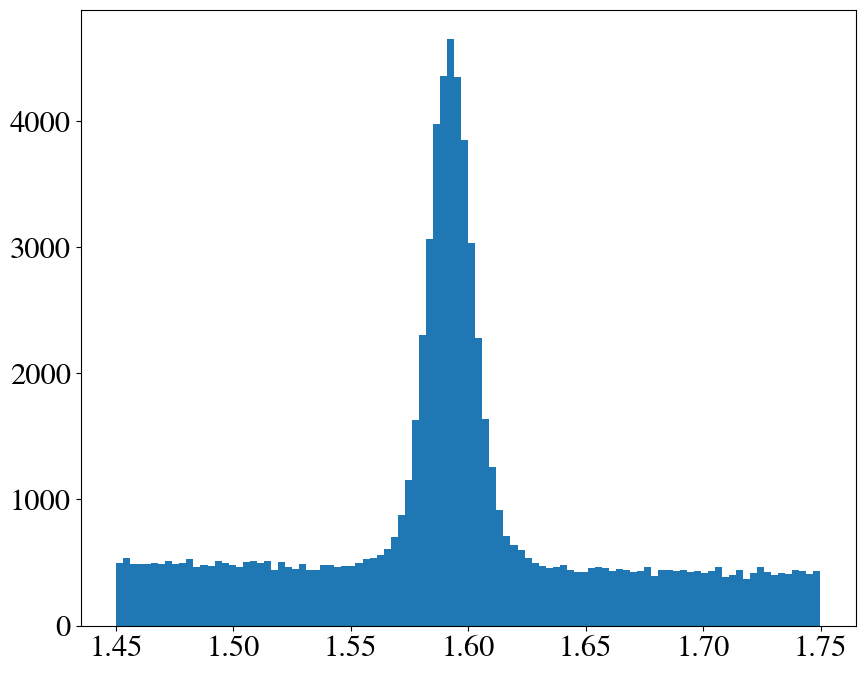

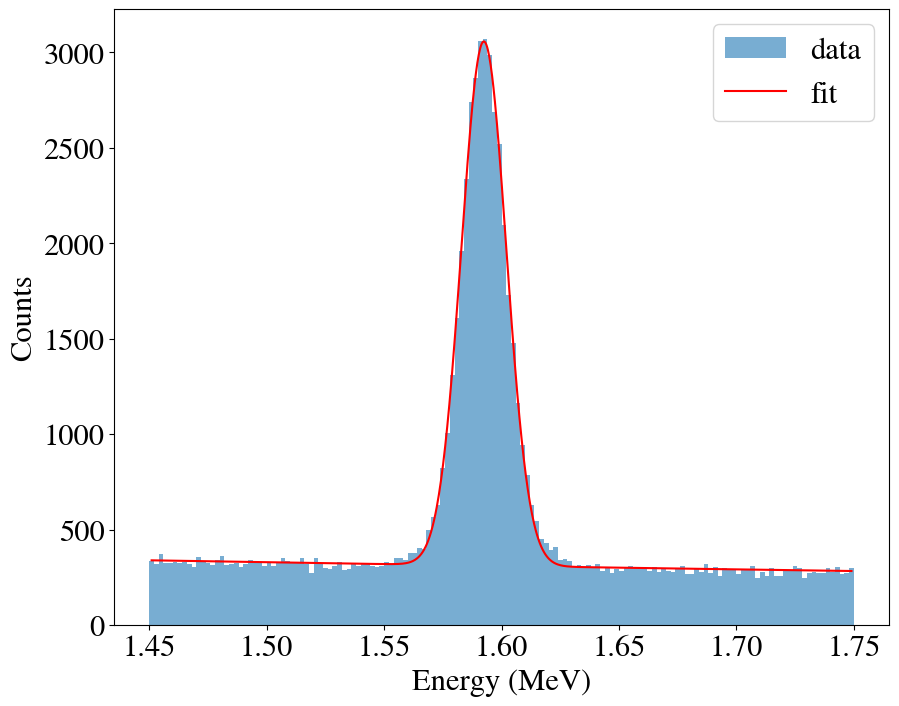

Signal events: 32874.69603785417
Background events: 46646.37932517615
Total Events by addition: 79521.07536303032
Total Events by row counting: 79520
FOM: [1.0, 1.0000047566266037, 1.000007308865403, 0.9999430878487394, 0.999854860577427]
fom_err: [0.00845265951237657, 0.008452732556368497, 0.008453077954256894, 0.008453590692284142, 0.008454642361243462]
ns_l: [32919.38102949515, 32918.97684386353, 32914.6115301814, 32899.766980129556, 32874.69603785417]
nb_l: [46759.69755625128, 46758.10450524169, 46745.46573672096, 46709.309865882096, 46646.37932517615]


Blob cut: 0.08333333333333333 MeV


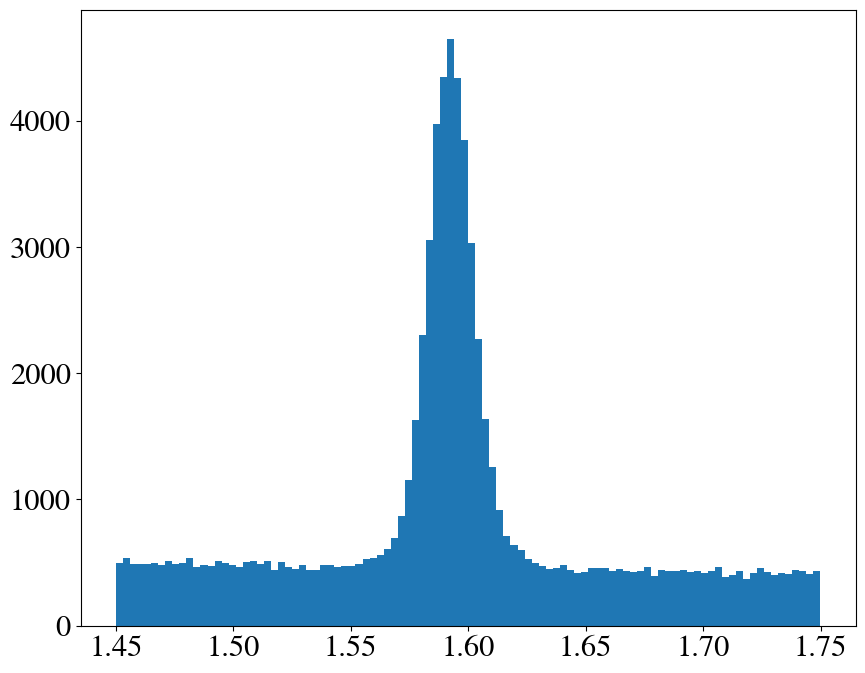

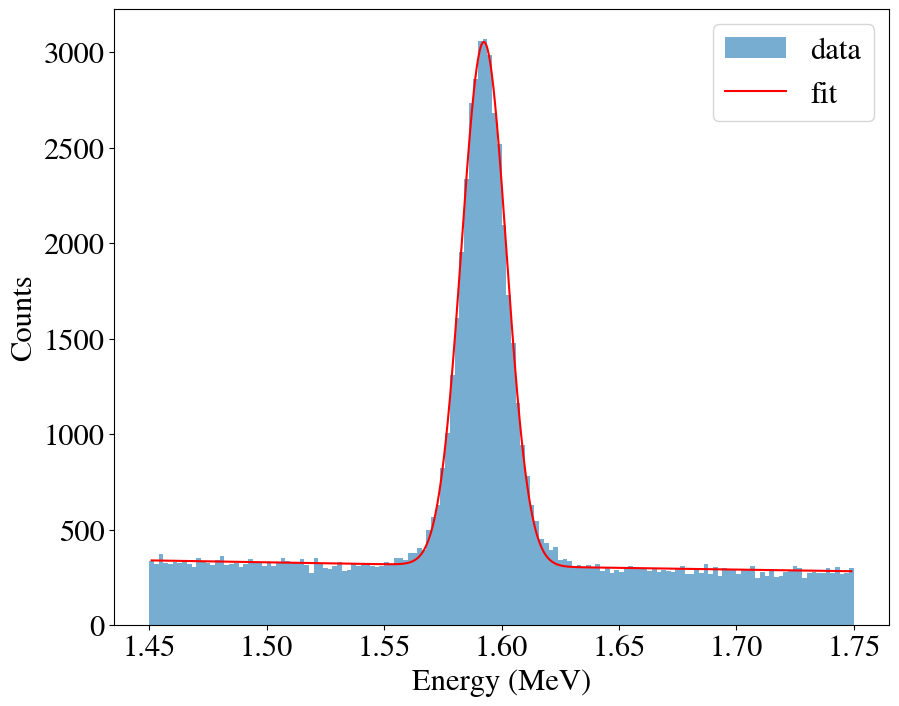

Signal events: 32846.09938238968
Background events: 46505.989698005884
Total Events by addition: 79352.08908039556
Total Events by row counting: 79351
FOM: [1.0, 1.0000047566266037, 1.000007308865403, 0.9999430878487394, 0.999854860577427, 1.0004918219410779]
fom_err: [0.00845265951237657, 0.008452732556368497, 0.008453077954256894, 0.008453590692284142, 0.008454642361243462, 0.008462551915633545]
ns_l: [32919.38102949515, 32918.97684386353, 32914.6115301814, 32899.766980129556, 32874.69603785417, 32846.09938238968]
nb_l: [46759.69755625128, 46758.10450524169, 46745.46573672096, 46709.309865882096, 46646.37932517615, 46505.989698005884]


Blob cut: 0.1 MeV


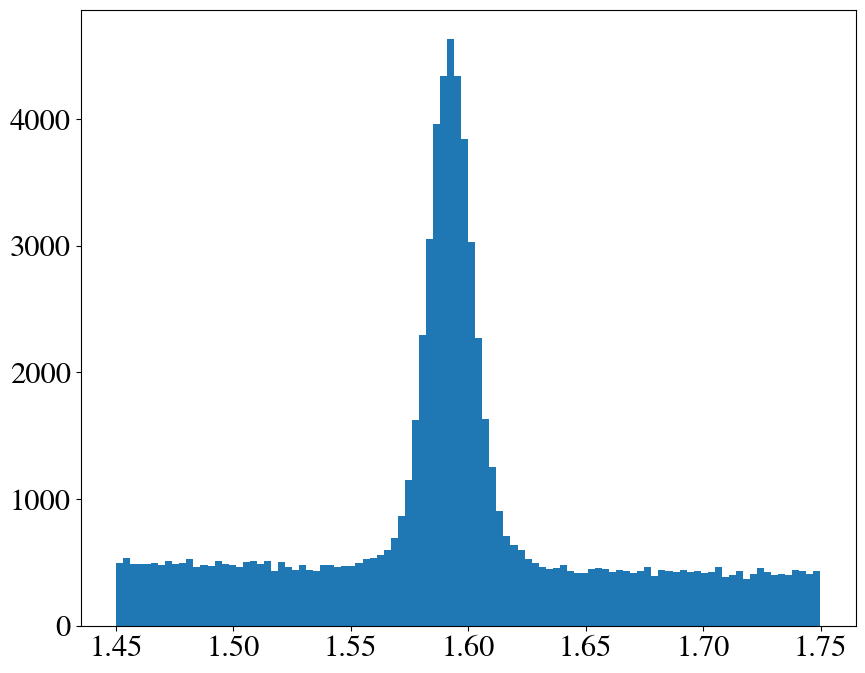

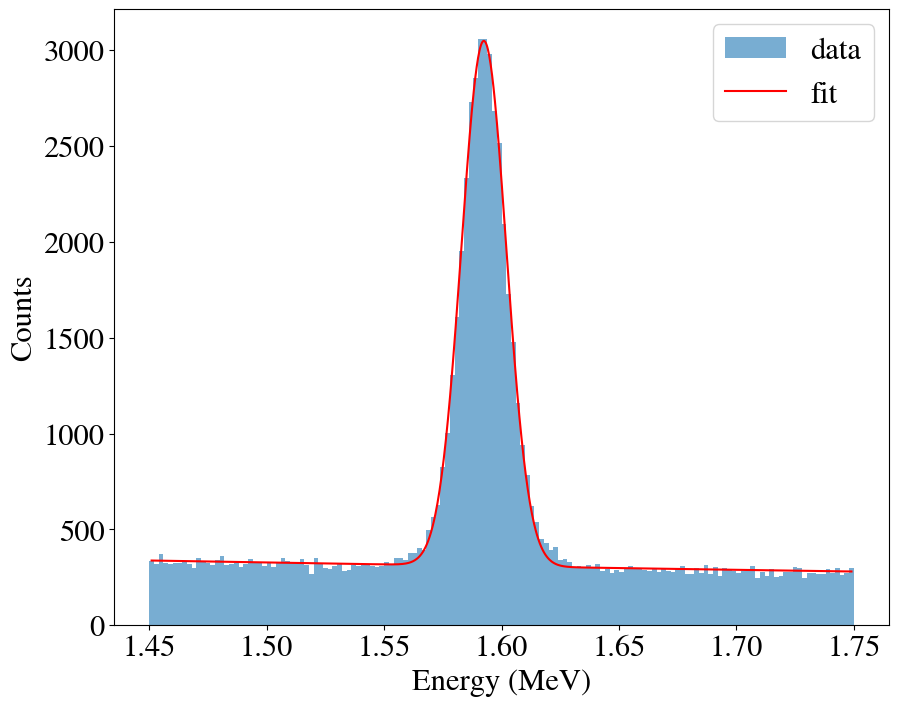

Signal events: 32823.96287951297
Background events: 46190.14779761702
Total Events by addition: 79014.11067713
Total Events by row counting: 79013
FOM: [1.0, 1.0000047566266037, 1.000007308865403, 0.9999430878487394, 0.999854860577427, 1.0004918219410779, 1.0032300283959155]
fom_err: [0.00845265951237657, 0.008452732556368497, 0.008453077954256894, 0.008453590692284142, 0.008454642361243462, 0.008462551915633545, 0.008489109581733318]
ns_l: [32919.38102949515, 32918.97684386353, 32914.6115301814, 32899.766980129556, 32874.69603785417, 32846.09938238968, 32823.96287951297]
nb_l: [46759.69755625128, 46758.10450524169, 46745.46573672096, 46709.309865882096, 46646.37932517615, 46505.989698005884, 46190.14779761702]


Blob cut: 0.11666666666666667 MeV


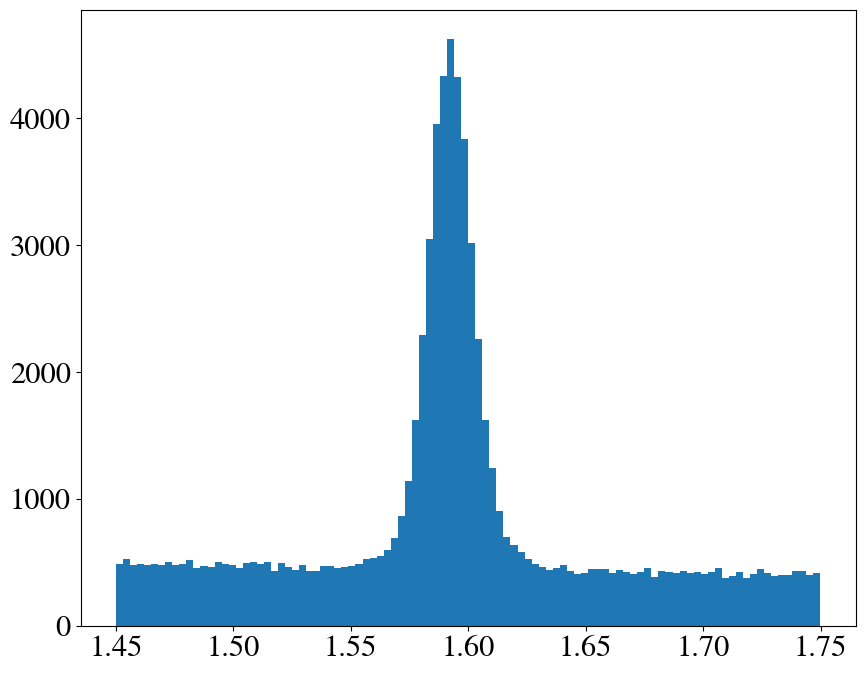

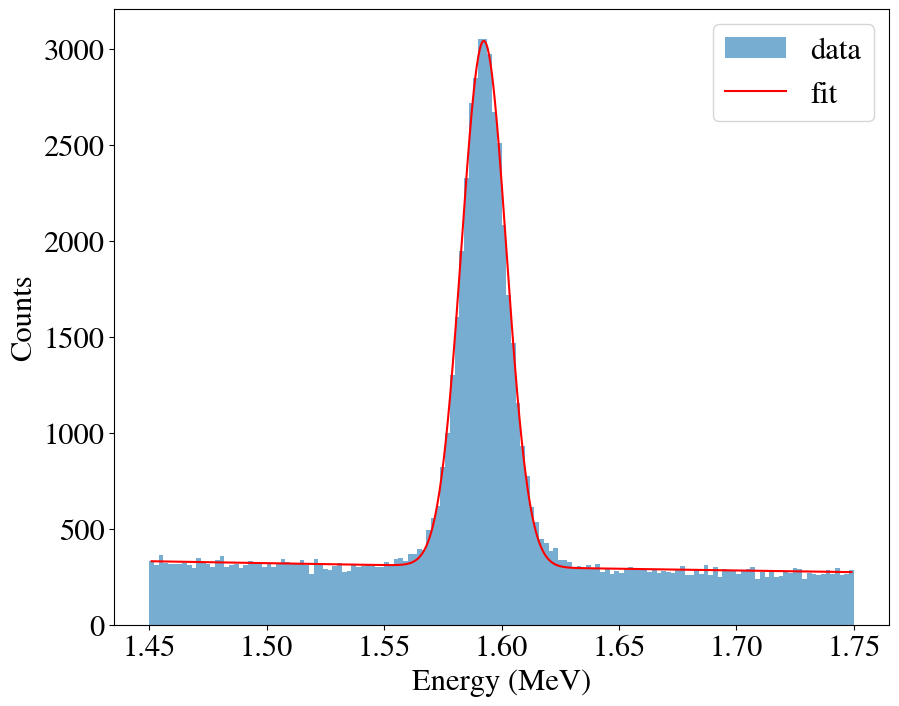

Signal events: 32797.03009735254
Background events: 45553.135190017696
Total Events by addition: 78350.16528737024
Total Events by row counting: 78349
FOM: [1.0, 1.0000047566266037, 1.000007308865403, 0.9999430878487394, 0.999854860577427, 1.0004918219410779, 1.0032300283959155, 1.0093913252418085]
fom_err: [0.00845265951237657, 0.008452732556368497, 0.008453077954256894, 0.008453590692284142, 0.008454642361243462, 0.008462551915633545, 0.008489109581733318, 0.0085472494631556]
ns_l: [32919.38102949515, 32918.97684386353, 32914.6115301814, 32899.766980129556, 32874.69603785417, 32846.09938238968, 32823.96287951297, 32797.03009735254]
nb_l: [46759.69755625128, 46758.10450524169, 46745.46573672096, 46709.309865882096, 46646.37932517615, 46505.989698005884, 46190.14779761702, 45553.135190017696]


Blob cut: 0.13333333333333333 MeV


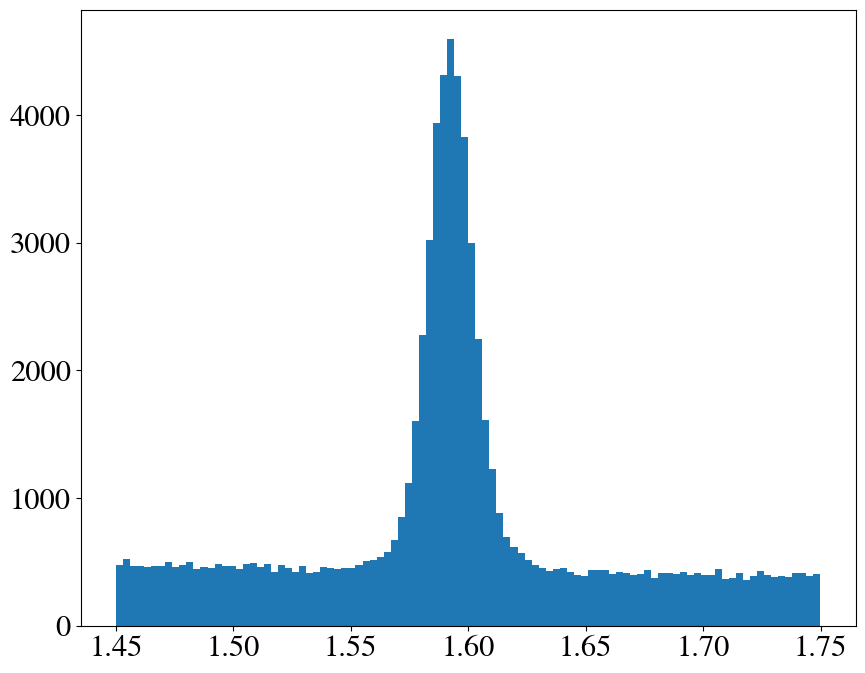

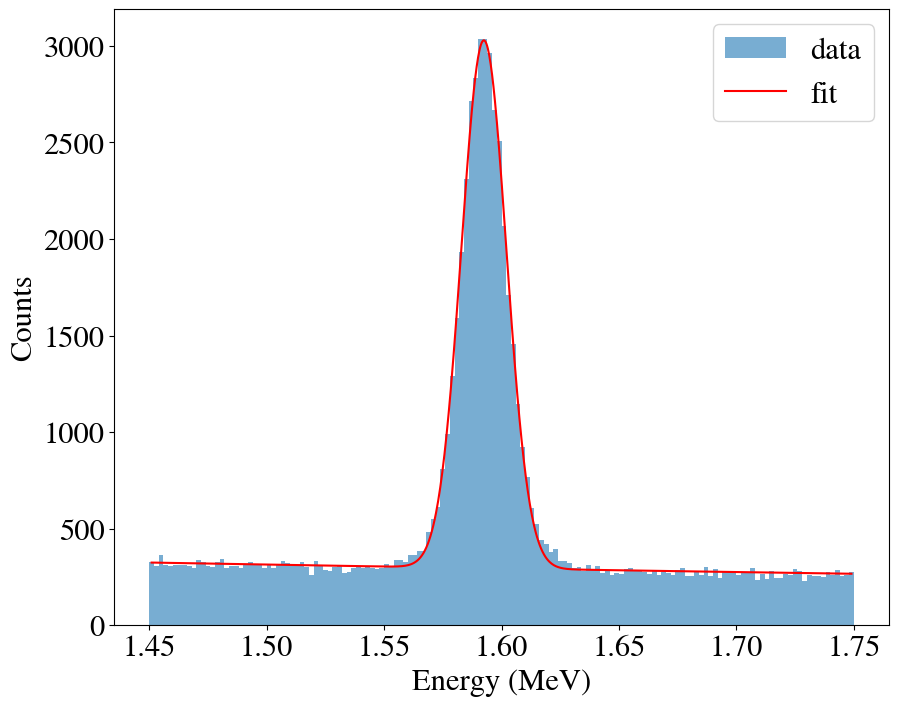

Signal events: 32752.393196344186
Background events: 44160.91025167313
Total Events by addition: 76913.30344801731
Total Events by row counting: 76912
FOM: [1.0, 1.0000047566266037, 1.000007308865403, 0.9999430878487394, 0.999854860577427, 1.0004918219410779, 1.0032300283959155, 1.0093913252418085, 1.0237837143583144]
fom_err: [0.00845265951237657, 0.008452732556368497, 0.008453077954256894, 0.008453590692284142, 0.008454642361243462, 0.008462551915633545, 0.008489109581733318, 0.0085472494631556, 0.008682081978903838]
ns_l: [32919.38102949515, 32918.97684386353, 32914.6115301814, 32899.766980129556, 32874.69603785417, 32846.09938238968, 32823.96287951297, 32797.03009735254, 32752.393196344186]
nb_l: [46759.69755625128, 46758.10450524169, 46745.46573672096, 46709.309865882096, 46646.37932517615, 46505.989698005884, 46190.14779761702, 45553.135190017696, 44160.91025167313]


Blob cut: 0.15 MeV


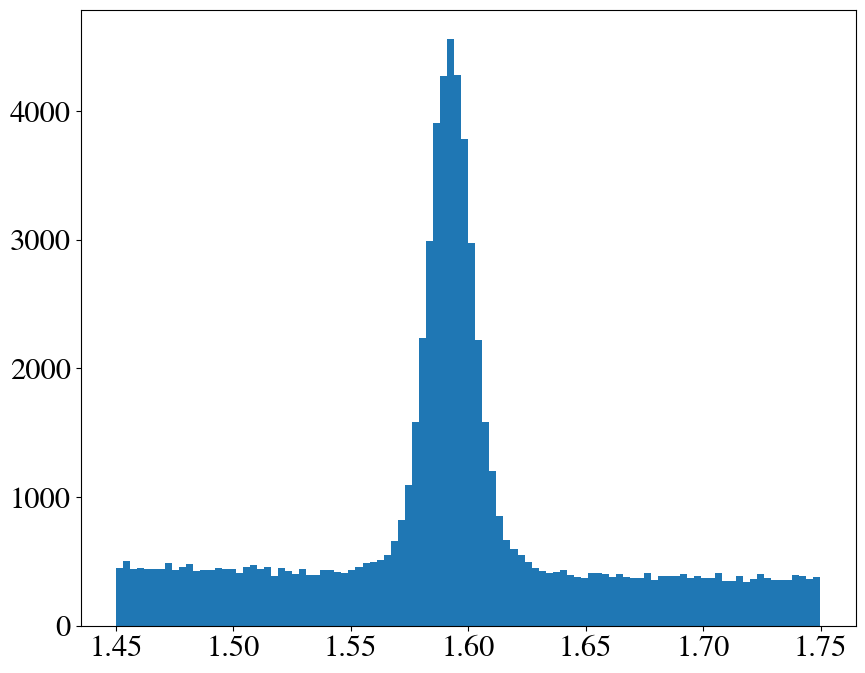

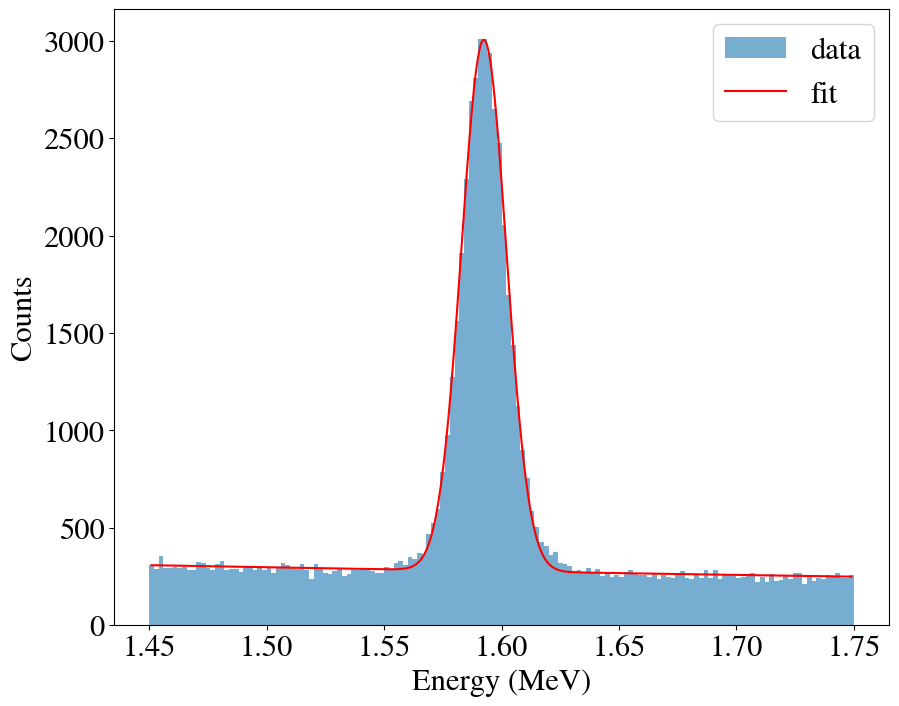

Signal events: 32667.520015463317
Background events: 41642.943233171725
Total Events by addition: 74310.46324863505
Total Events by row counting: 74309
FOM: [1.0, 1.0000047566266037, 1.000007308865403, 0.9999430878487394, 0.999854860577427, 1.0004918219410779, 1.0032300283959155, 1.0093913252418085, 1.0237837143583144, 1.051549311568224]
fom_err: [0.00845265951237657, 0.008452732556368497, 0.008453077954256894, 0.008453590692284142, 0.008454642361243462, 0.008462551915633545, 0.008489109581733318, 0.0085472494631556, 0.008682081978903838, 0.008943647264651662]
ns_l: [32919.38102949515, 32918.97684386353, 32914.6115301814, 32899.766980129556, 32874.69603785417, 32846.09938238968, 32823.96287951297, 32797.03009735254, 32752.393196344186, 32667.520015463317]
nb_l: [46759.69755625128, 46758.10450524169, 46745.46573672096, 46709.309865882096, 46646.37932517615, 46505.989698005884, 46190.14779761702, 45553.135190017696, 44160.91025167313, 41642.943233171725]


Blob cut: 0.16666666666666666 M

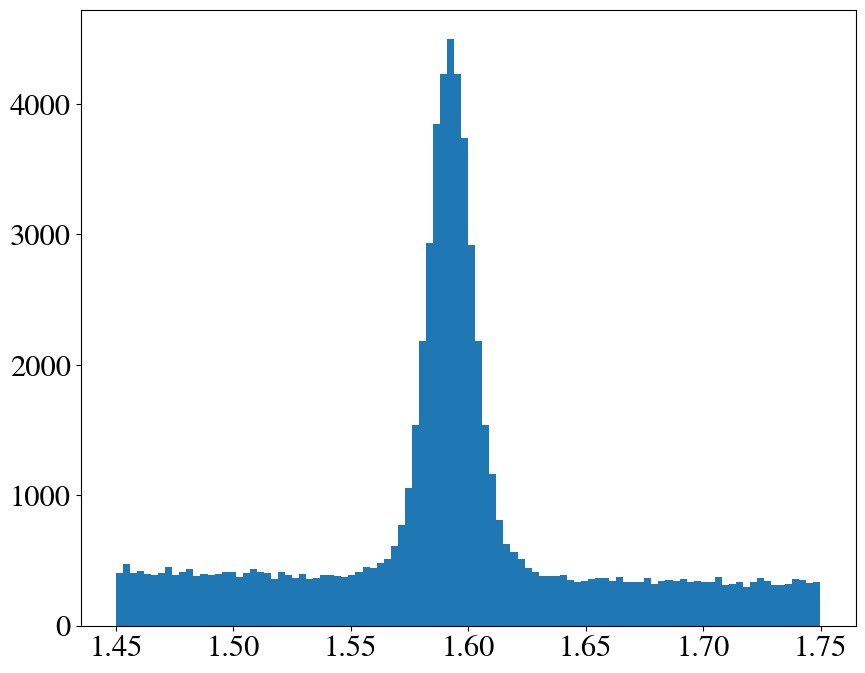

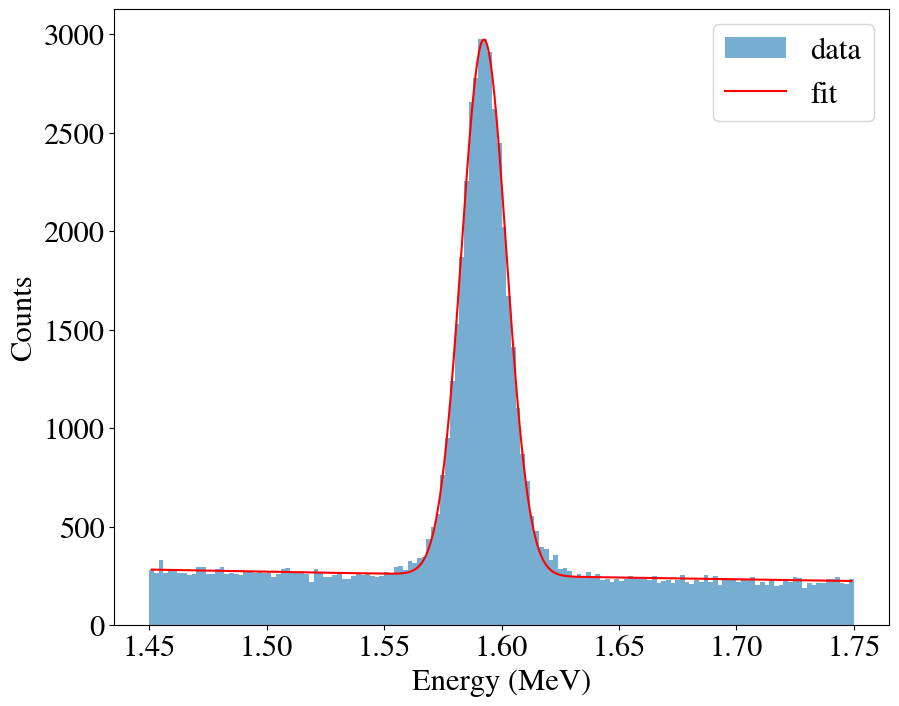

Signal events: 32551.827231108568
Background events: 37819.88536295028
Total Events by addition: 70371.71259405884
Total Events by row counting: 70370
FOM: [1.0, 1.0000047566266037, 1.000007308865403, 0.9999430878487394, 0.999854860577427, 1.0004918219410779, 1.0032300283959155, 1.0093913252418085, 1.0237837143583144, 1.051549311568224, 1.09951068396915]
fom_err: [0.00845265951237657, 0.008452732556368497, 0.008453077954256894, 0.008453590692284142, 0.008454642361243462, 0.008462551915633545, 0.008489109581733318, 0.0085472494631556, 0.008682081978903838, 0.008943647264651662, 0.009397713239436131]
ns_l: [32919.38102949515, 32918.97684386353, 32914.6115301814, 32899.766980129556, 32874.69603785417, 32846.09938238968, 32823.96287951297, 32797.03009735254, 32752.393196344186, 32667.520015463317, 32551.827231108568]
nb_l: [46759.69755625128, 46758.10450524169, 46745.46573672096, 46709.309865882096, 46646.37932517615, 46505.989698005884, 46190.14779761702, 45553.135190017696, 44160.9102516

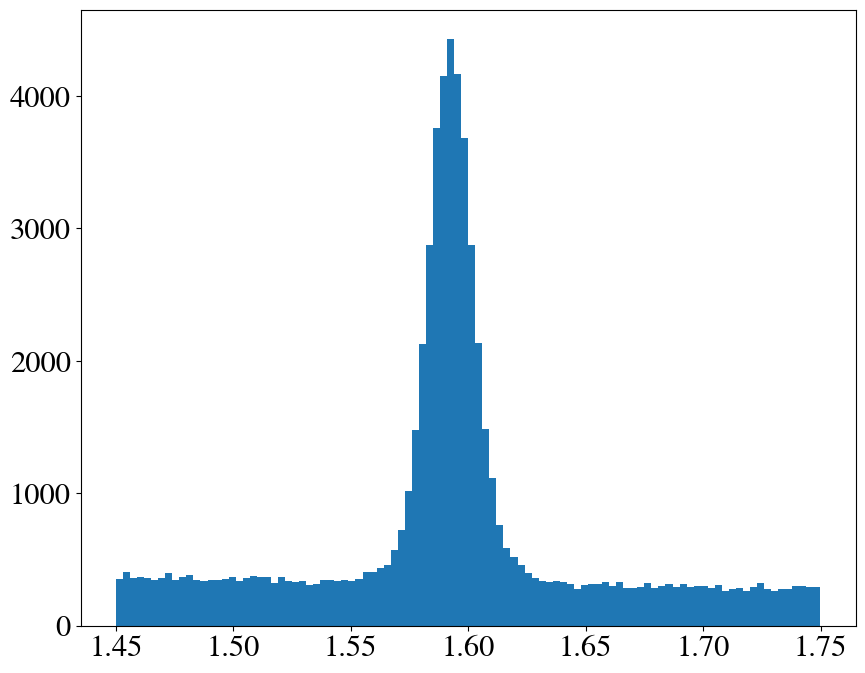

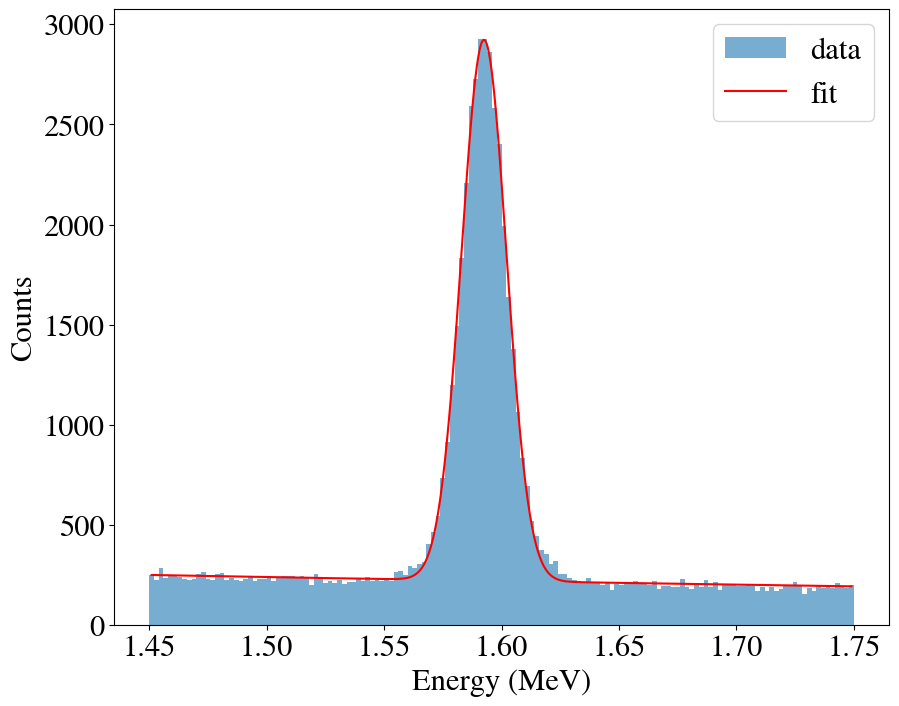

Signal events: 32379.199381880913
Background events: 33185.089545756964
Total Events by addition: 65564.28892763788
Total Events by row counting: 65562
FOM: [1.0, 1.0000047566266037, 1.000007308865403, 0.9999430878487394, 0.999854860577427, 1.0004918219410779, 1.0032300283959155, 1.0093913252418085, 1.0237837143583144, 1.051549311568224, 1.09951068396915, 1.1675588903239131]
fom_err: [0.00845265951237657, 0.008452732556368497, 0.008453077954256894, 0.008453590692284142, 0.008454642361243462, 0.008462551915633545, 0.008489109581733318, 0.0085472494631556, 0.008682081978903838, 0.008943647264651662, 0.009397713239436131, 0.010053302769983988]
ns_l: [32919.38102949515, 32918.97684386353, 32914.6115301814, 32899.766980129556, 32874.69603785417, 32846.09938238968, 32823.96287951297, 32797.03009735254, 32752.393196344186, 32667.520015463317, 32551.827231108568, 32379.199381880913]
nb_l: [46759.69755625128, 46758.10450524169, 46745.46573672096, 46709.309865882096, 46646.37932517615, 46505.989

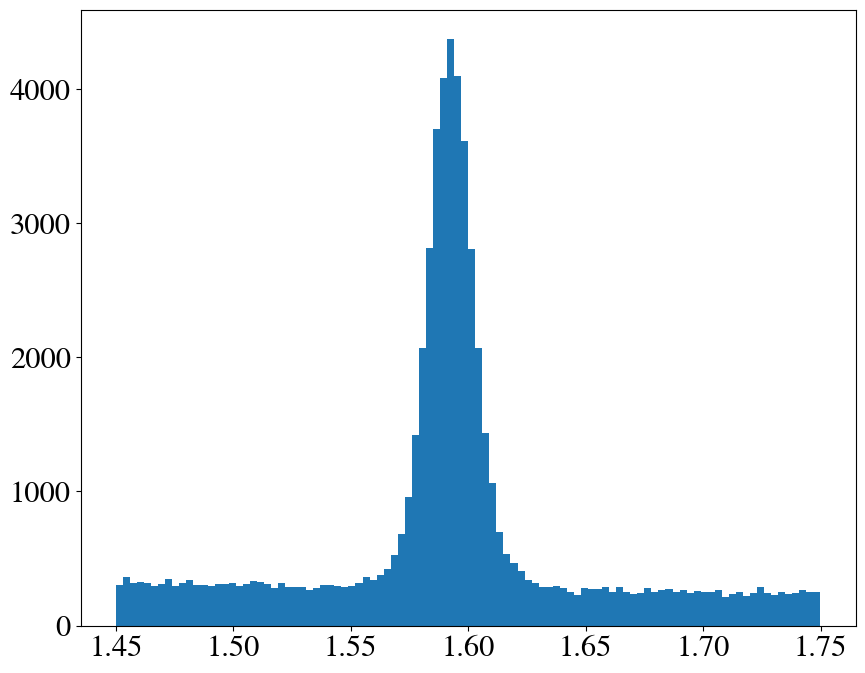

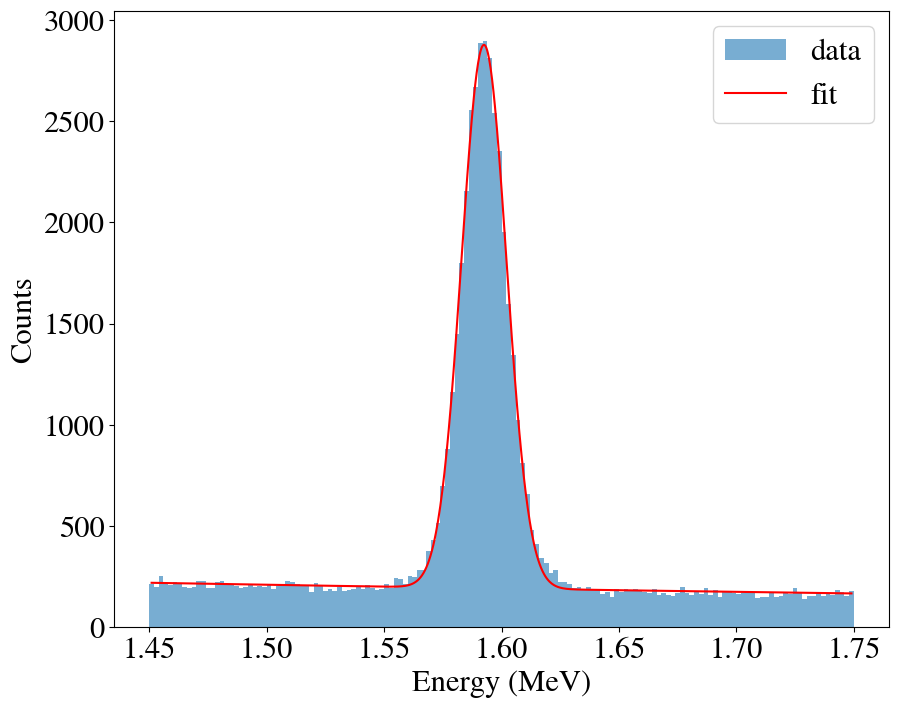

Signal events: 32127.612261390346
Background events: 28794.621847829378
Total Events by addition: 60922.234109219724
Total Events by row counting: 60920
FOM: [1.0, 1.0000047566266037, 1.000007308865403, 0.9999430878487394, 0.999854860577427, 1.0004918219410779, 1.0032300283959155, 1.0093913252418085, 1.0237837143583144, 1.051549311568224, 1.09951068396915, 1.1675588903239131, 1.2436751194446318]
fom_err: [0.00845265951237657, 0.008452732556368497, 0.008453077954256894, 0.008453590692284142, 0.008454642361243462, 0.008462551915633545, 0.008489109581733318, 0.0085472494631556, 0.008682081978903838, 0.008943647264651662, 0.009397713239436131, 0.010053302769983988, 0.010808658538013332]
ns_l: [32919.38102949515, 32918.97684386353, 32914.6115301814, 32899.766980129556, 32874.69603785417, 32846.09938238968, 32823.96287951297, 32797.03009735254, 32752.393196344186, 32667.520015463317, 32551.827231108568, 32379.199381880913, 32127.612261390346]
nb_l: [46759.69755625128, 46758.10450524169, 4674

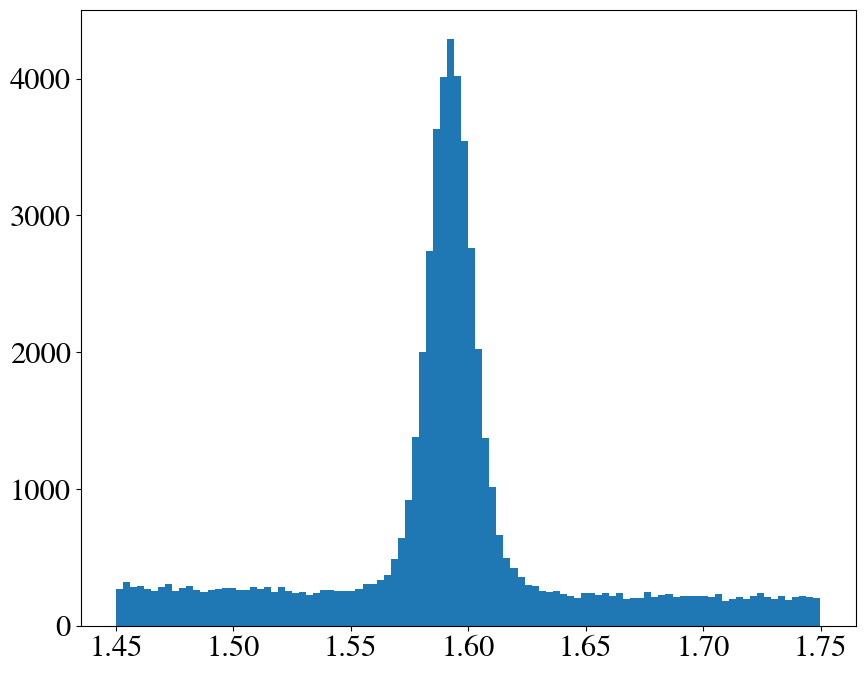

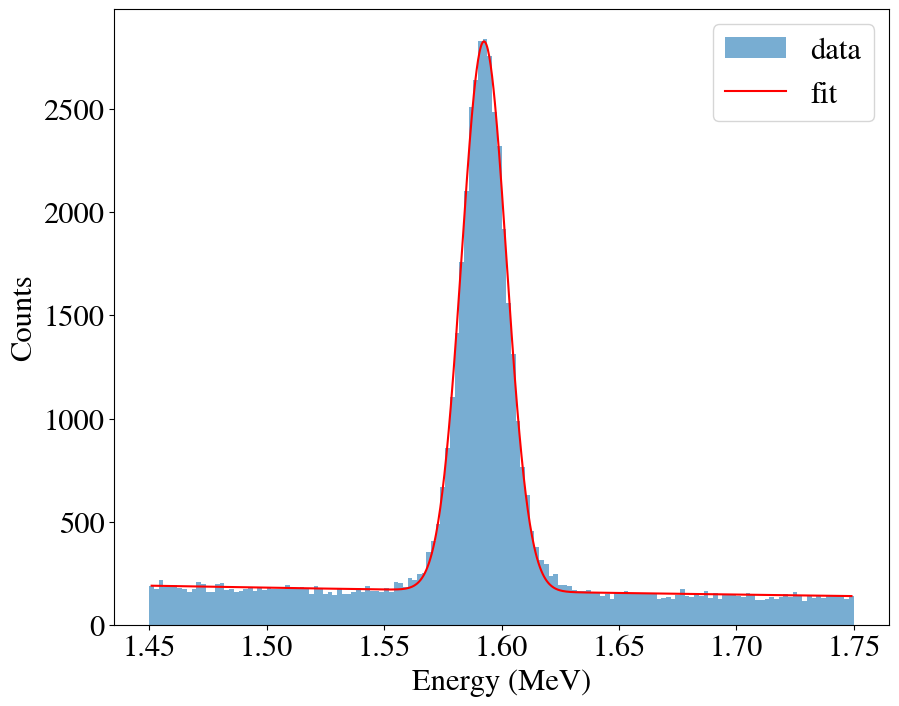

Signal events: 31857.417060269585
Background events: 24713.208402549604
Total Events by addition: 56570.62546281919
Total Events by row counting: 56568
FOM: [1.0, 1.0000047566266037, 1.000007308865403, 0.9999430878487394, 0.999854860577427, 1.0004918219410779, 1.0032300283959155, 1.0093913252418085, 1.0237837143583144, 1.051549311568224, 1.09951068396915, 1.1675588903239131, 1.2436751194446318, 1.3311597618344269]
fom_err: [0.00845265951237657, 0.008452732556368497, 0.008453077954256894, 0.008453590692284142, 0.008454642361243462, 0.008462551915633545, 0.008489109581733318, 0.0085472494631556, 0.008682081978903838, 0.008943647264651662, 0.009397713239436131, 0.010053302769983988, 0.010808658538013332, 0.01169828459901837]
ns_l: [32919.38102949515, 32918.97684386353, 32914.6115301814, 32899.766980129556, 32874.69603785417, 32846.09938238968, 32823.96287951297, 32797.03009735254, 32752.393196344186, 32667.520015463317, 32551.827231108568, 32379.199381880913, 32127.612261390346, 31857.417

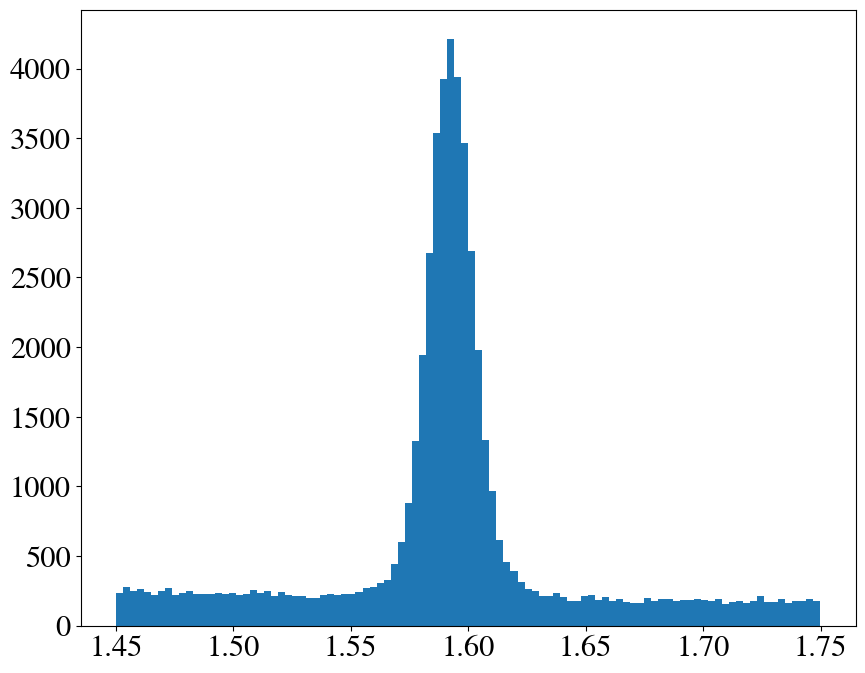

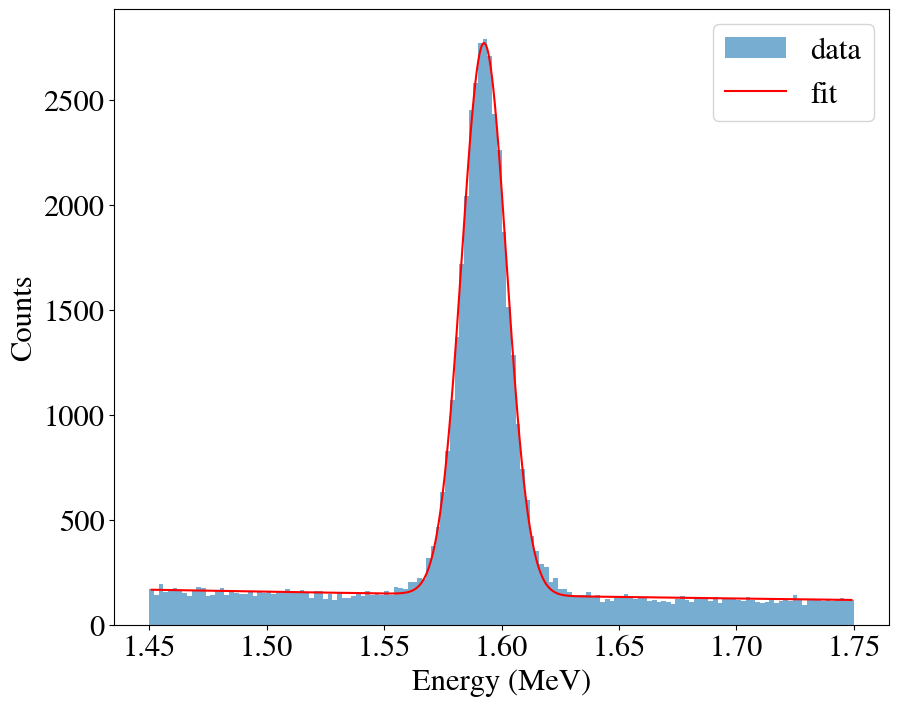

Signal events: 31421.015266030692
Background events: 21459.0431042587
Total Events by addition: 52880.05837028939
Total Events by row counting: 52877
FOM: [1.0, 1.0000047566266037, 1.000007308865403, 0.9999430878487394, 0.999854860577427, 1.0004918219410779, 1.0032300283959155, 1.0093913252418085, 1.0237837143583144, 1.051549311568224, 1.09951068396915, 1.1675588903239131, 1.2436751194446318, 1.3311597618344269, 1.408961816344627]
fom_err: [0.00845265951237657, 0.008452732556368497, 0.008453077954256894, 0.008453590692284142, 0.008454642361243462, 0.008462551915633545, 0.008489109581733318, 0.0085472494631556, 0.008682081978903838, 0.008943647264651662, 0.009397713239436131, 0.010053302769983988, 0.010808658538013332, 0.01169828459901837, 0.012538941674250735]
ns_l: [32919.38102949515, 32918.97684386353, 32914.6115301814, 32899.766980129556, 32874.69603785417, 32846.09938238968, 32823.96287951297, 32797.03009735254, 32752.393196344186, 32667.520015463317, 32551.827231108568, 32379.1993

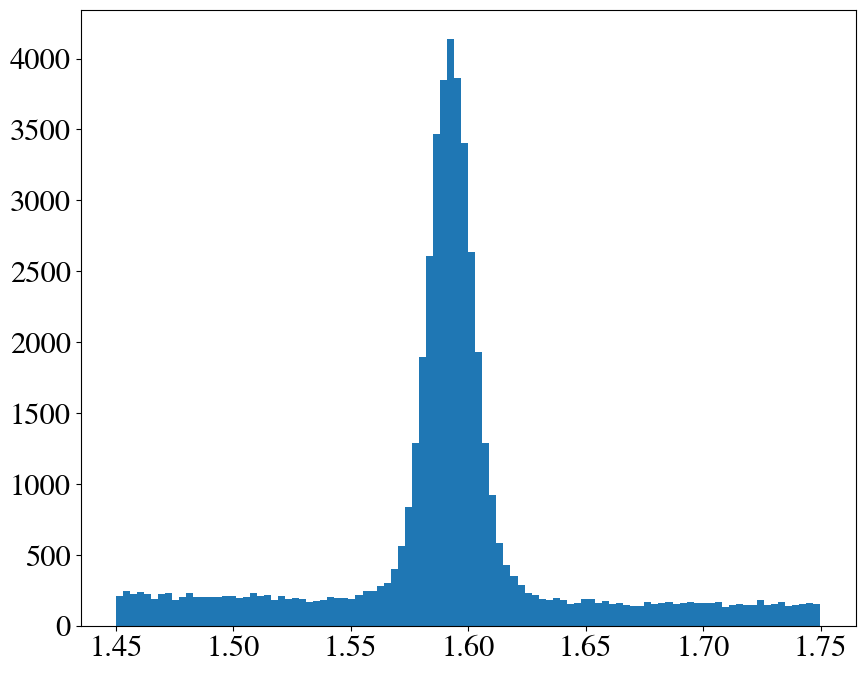

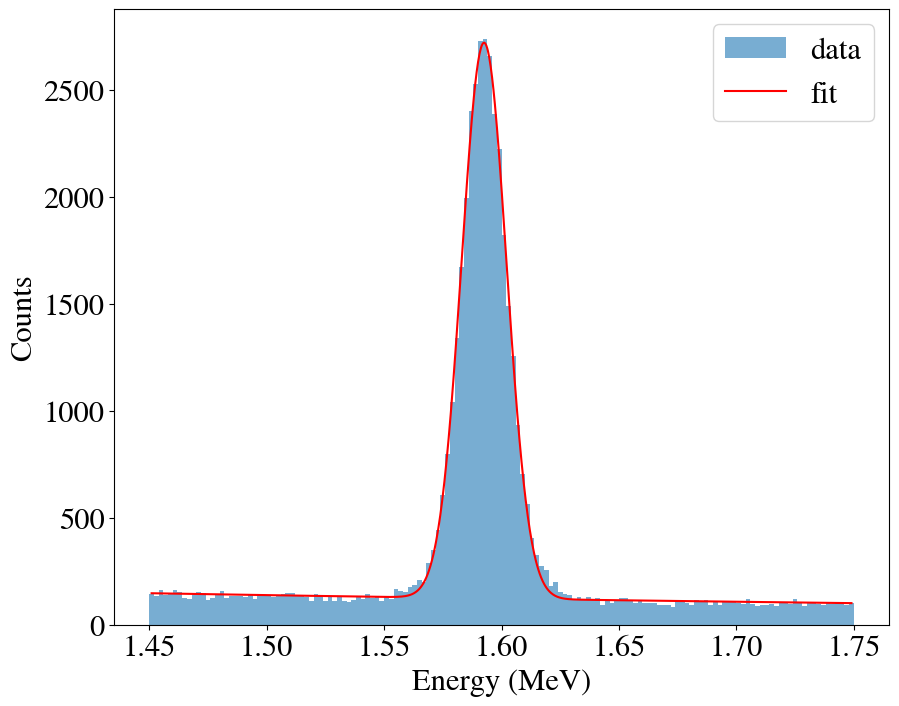

Signal events: 31018.115371954478
Background events: 18695.310667799837
Total Events by addition: 49713.42603975431
Total Events by row counting: 49710
FOM: [1.0, 1.0000047566266037, 1.000007308865403, 0.9999430878487394, 0.999854860577427, 1.0004918219410779, 1.0032300283959155, 1.0093913252418085, 1.0237837143583144, 1.051549311568224, 1.09951068396915, 1.1675588903239131, 1.2436751194446318, 1.3311597618344269, 1.408961816344627, 1.4901611948599833]
fom_err: [0.00845265951237657, 0.008452732556368497, 0.008453077954256894, 0.008453590692284142, 0.008454642361243462, 0.008462551915633545, 0.008489109581733318, 0.0085472494631556, 0.008682081978903838, 0.008943647264651662, 0.009397713239436131, 0.010053302769983988, 0.010808658538013332, 0.01169828459901837, 0.012538941674250735, 0.013439179543636468]
ns_l: [32919.38102949515, 32918.97684386353, 32914.6115301814, 32899.766980129556, 32874.69603785417, 32846.09938238968, 32823.96287951297, 32797.03009735254, 32752.393196344186, 32667.

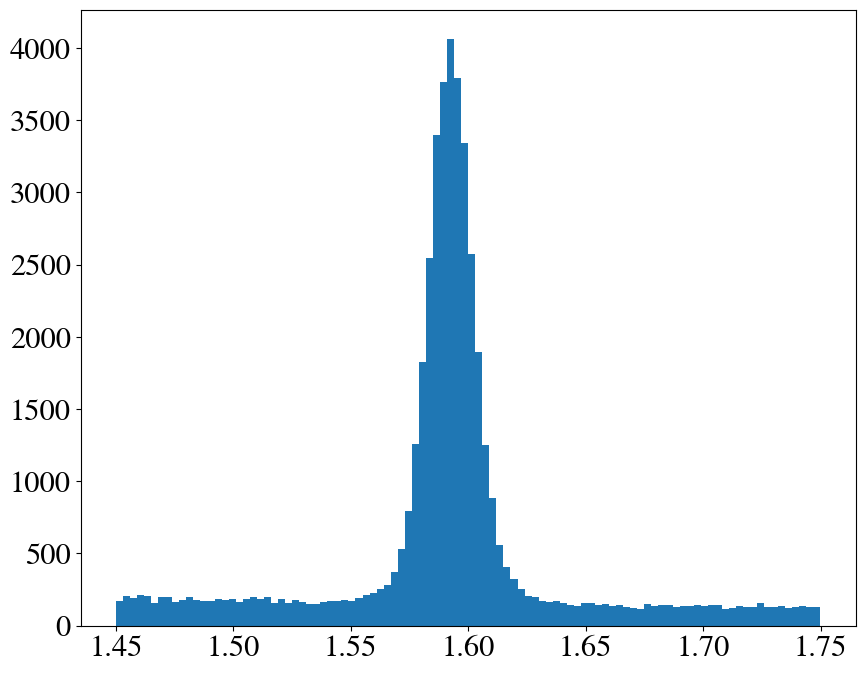

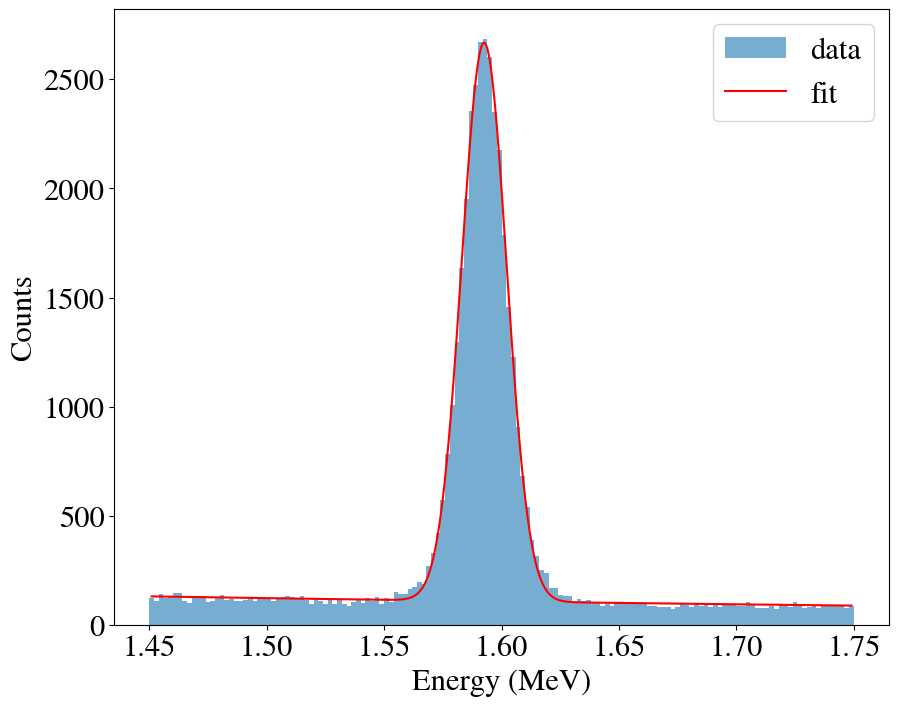

Signal events: 30550.675730705796
Background events: 16422.279211161676
Total Events by addition: 46972.95494186747
Total Events by row counting: 46969
FOM: [1.0, 1.0000047566266037, 1.000007308865403, 0.9999430878487394, 0.999854860577427, 1.0004918219410779, 1.0032300283959155, 1.0093913252418085, 1.0237837143583144, 1.051549311568224, 1.09951068396915, 1.1675588903239131, 1.2436751194446318, 1.3311597618344269, 1.408961816344627, 1.4901611948599833, 1.565987498465873]
fom_err: [0.00845265951237657, 0.008452732556368497, 0.008453077954256894, 0.008453590692284142, 0.008454642361243462, 0.008462551915633545, 0.008489109581733318, 0.0085472494631556, 0.008682081978903838, 0.008943647264651662, 0.009397713239436131, 0.010053302769983988, 0.010808658538013332, 0.01169828459901837, 0.012538941674250735, 0.013439179543636468, 0.014325101087555615]
ns_l: [32919.38102949515, 32918.97684386353, 32914.6115301814, 32899.766980129556, 32874.69603785417, 32846.09938238968, 32823.96287951297, 3279

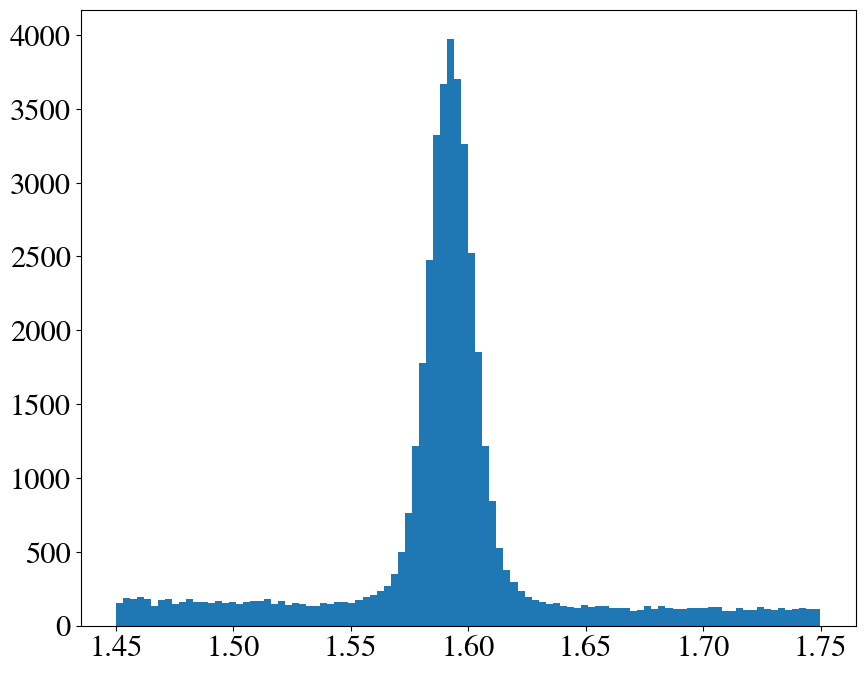

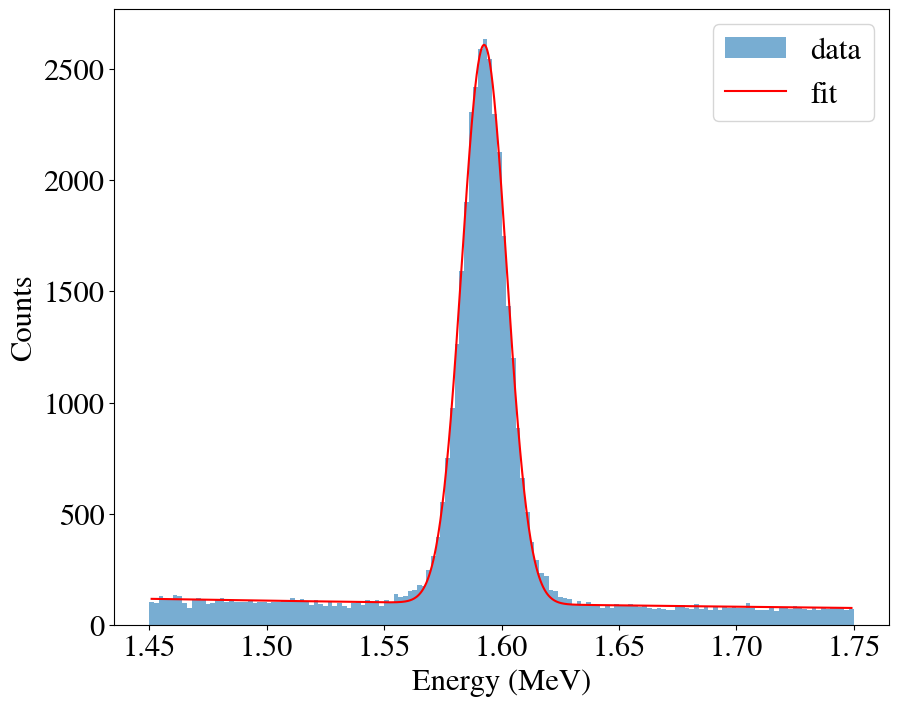

Signal events: 30005.489258634356
Background events: 14467.557345918343
Total Events by addition: 44473.0466045527
Total Events by row counting: 44468
FOM: [1.0, 1.0000047566266037, 1.000007308865403, 0.9999430878487394, 0.999854860577427, 1.0004918219410779, 1.0032300283959155, 1.0093913252418085, 1.0237837143583144, 1.051549311568224, 1.09951068396915, 1.1675588903239131, 1.2436751194446318, 1.3311597618344269, 1.408961816344627, 1.4901611948599833, 1.565987498465873, 1.6386541128592285]
fom_err: [0.00845265951237657, 0.008452732556368497, 0.008453077954256894, 0.008453590692284142, 0.008454642361243462, 0.008462551915633545, 0.008489109581733318, 0.0085472494631556, 0.008682081978903838, 0.008943647264651662, 0.009397713239436131, 0.010053302769983988, 0.010808658538013332, 0.01169828459901837, 0.012538941674250735, 0.013439179543636468, 0.014325101087555615, 0.015225469290095401]
ns_l: [32919.38102949515, 32918.97684386353, 32914.6115301814, 32899.766980129556, 32874.69603785417, 3

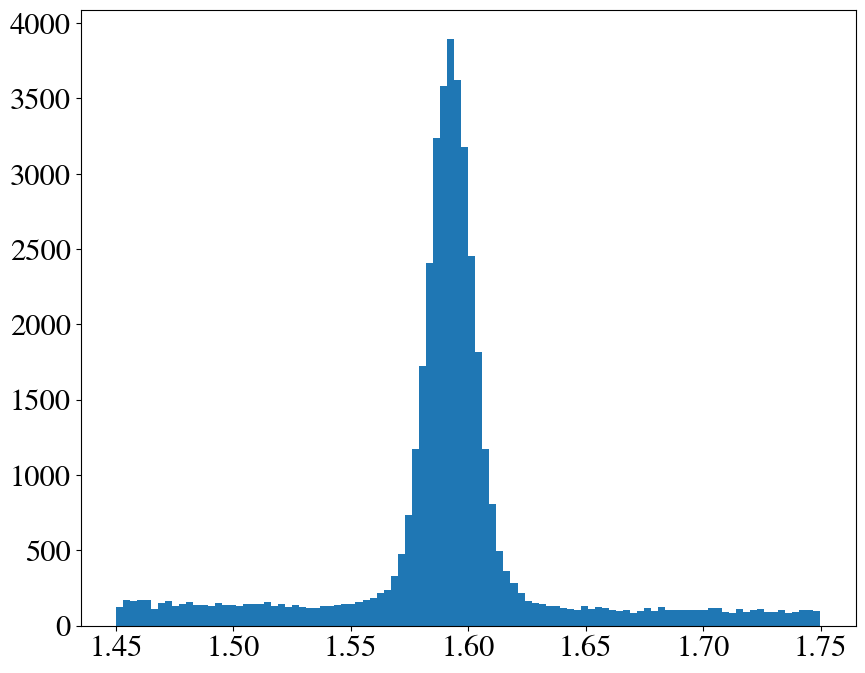

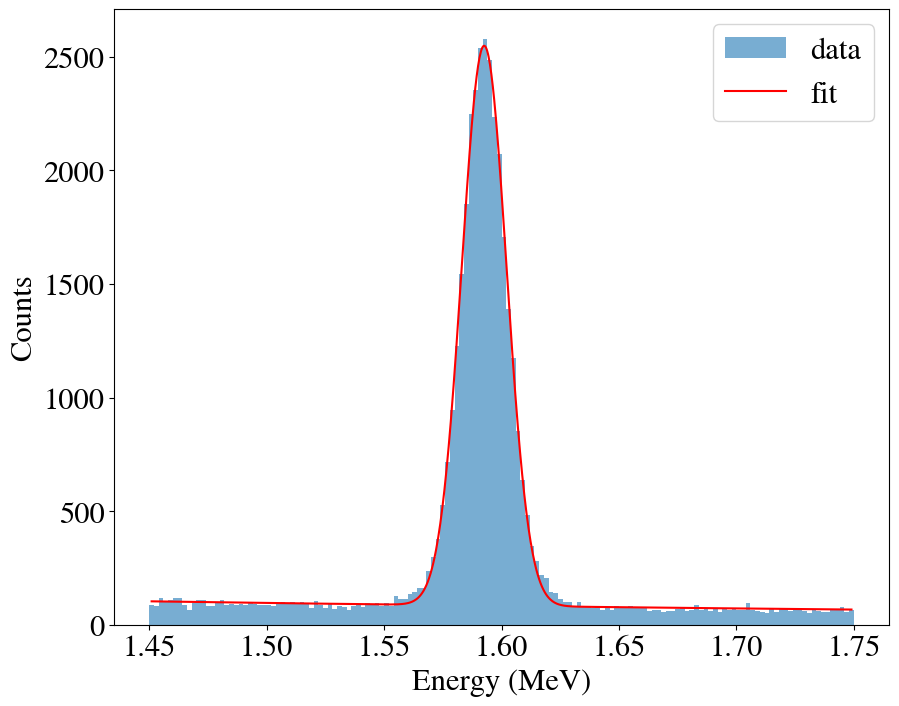

Signal events: 29365.053819735713
Background events: 12842.595692285124
Total Events by addition: 42207.649512020835
Total Events by row counting: 42203
FOM: [1.0, 1.0000047566266037, 1.000007308865403, 0.9999430878487394, 0.999854860577427, 1.0004918219410779, 1.0032300283959155, 1.0093913252418085, 1.0237837143583144, 1.051549311568224, 1.09951068396915, 1.1675588903239131, 1.2436751194446318, 1.3311597618344269, 1.408961816344627, 1.4901611948599833, 1.565987498465873, 1.6386541128592285, 1.7021137574023157]
fom_err: [0.00845265951237657, 0.008452732556368497, 0.008453077954256894, 0.008453590692284142, 0.008454642361243462, 0.008462551915633545, 0.008489109581733318, 0.0085472494631556, 0.008682081978903838, 0.008943647264651662, 0.009397713239436131, 0.010053302769983988, 0.010808658538013332, 0.01169828459901837, 0.012538941674250735, 0.013439179543636468, 0.014325101087555615, 0.015225469290095401, 0.01607973090385951]
ns_l: [32919.38102949515, 32918.97684386353, 32914.611530181

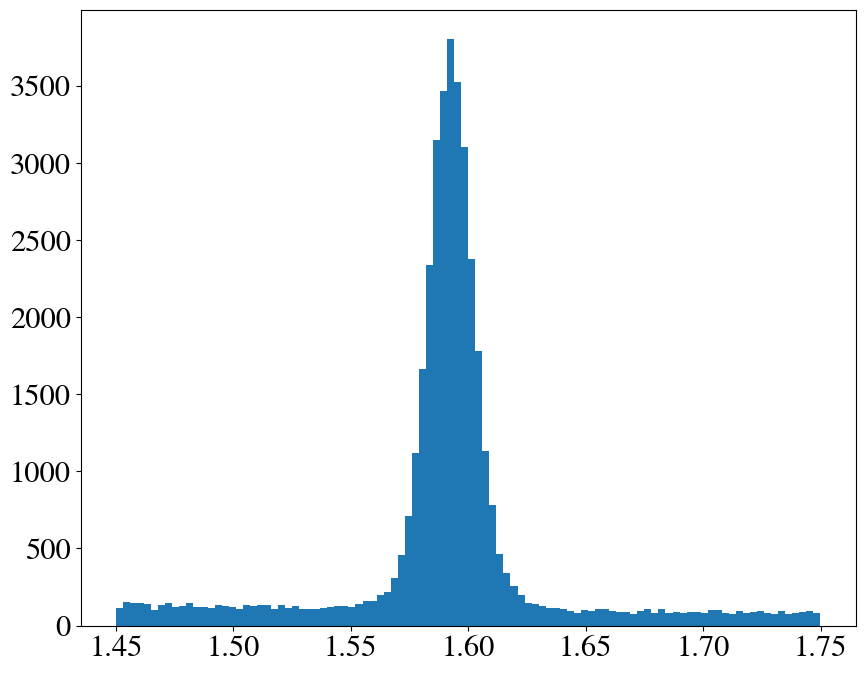

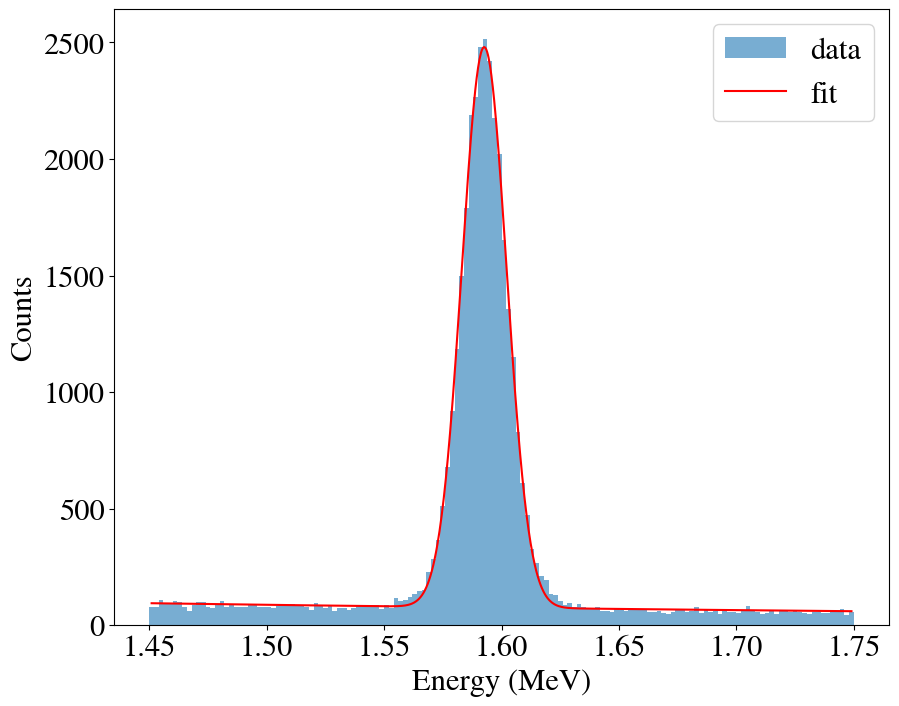

Signal events: 28665.722777370633
Background events: 11379.58977185195
Total Events by addition: 40045.31254922258
Total Events by row counting: 40040
FOM: [1.0, 1.0000047566266037, 1.000007308865403, 0.9999430878487394, 0.999854860577427, 1.0004918219410779, 1.0032300283959155, 1.0093913252418085, 1.0237837143583144, 1.051549311568224, 1.09951068396915, 1.1675588903239131, 1.2436751194446318, 1.3311597618344269, 1.408961816344627, 1.4901611948599833, 1.565987498465873, 1.6386541128592285, 1.7021137574023157, 1.7651587887816091]
fom_err: [0.00845265951237657, 0.008452732556368497, 0.008453077954256894, 0.008453590692284142, 0.008454642361243462, 0.008462551915633545, 0.008489109581733318, 0.0085472494631556, 0.008682081978903838, 0.008943647264651662, 0.009397713239436131, 0.010053302769983988, 0.010808658538013332, 0.01169828459901837, 0.012538941674250735, 0.013439179543636468, 0.014325101087555615, 0.015225469290095401, 0.01607973090385951, 0.016983887261414553]
ns_l: [32919.3810294

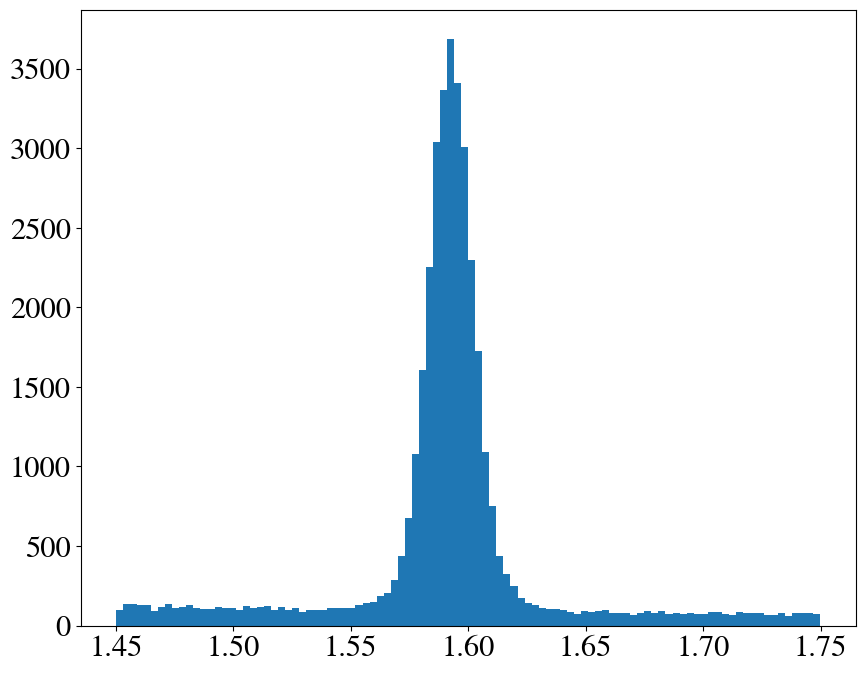

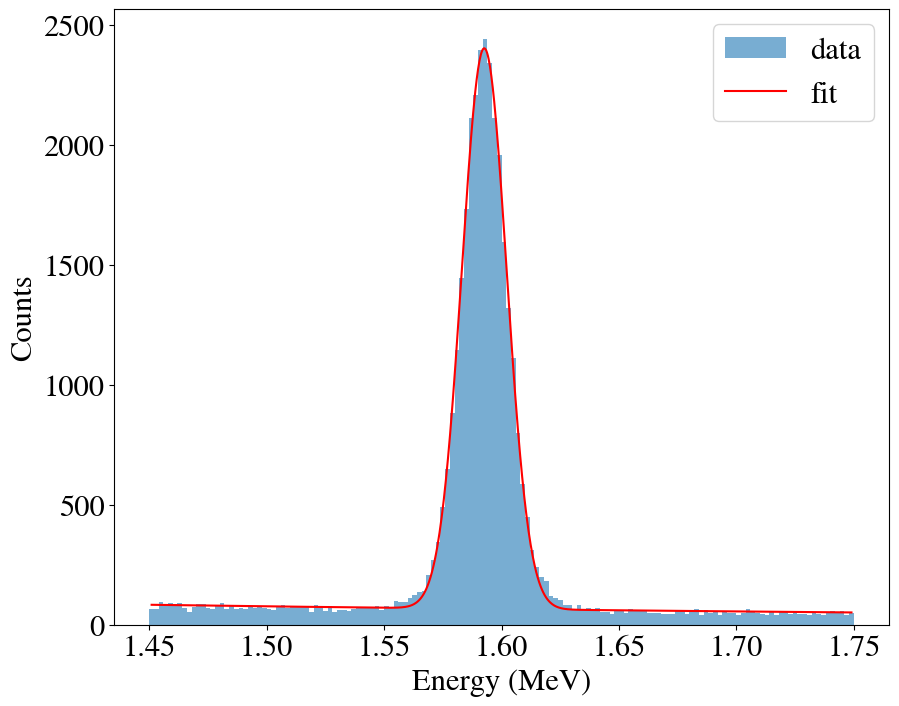

Signal events: 27837.602222189133
Background events: 10171.912965478565
Total Events by addition: 38009.5151876677
Total Events by row counting: 38004
FOM: [1.0, 1.0000047566266037, 1.000007308865403, 0.9999430878487394, 0.999854860577427, 1.0004918219410779, 1.0032300283959155, 1.0093913252418085, 1.0237837143583144, 1.051549311568224, 1.09951068396915, 1.1675588903239131, 1.2436751194446318, 1.3311597618344269, 1.408961816344627, 1.4901611948599833, 1.565987498465873, 1.6386541128592285, 1.7021137574023157, 1.7651587887816091, 1.8130705056957424]
fom_err: [0.00845265951237657, 0.008452732556368497, 0.008453077954256894, 0.008453590692284142, 0.008454642361243462, 0.008462551915633545, 0.008489109581733318, 0.0085472494631556, 0.008682081978903838, 0.008943647264651662, 0.009397713239436131, 0.010053302769983988, 0.010808658538013332, 0.01169828459901837, 0.012538941674250735, 0.013439179543636468, 0.014325101087555615, 0.015225469290095401, 0.01607973090385951, 0.016983887261414553, 

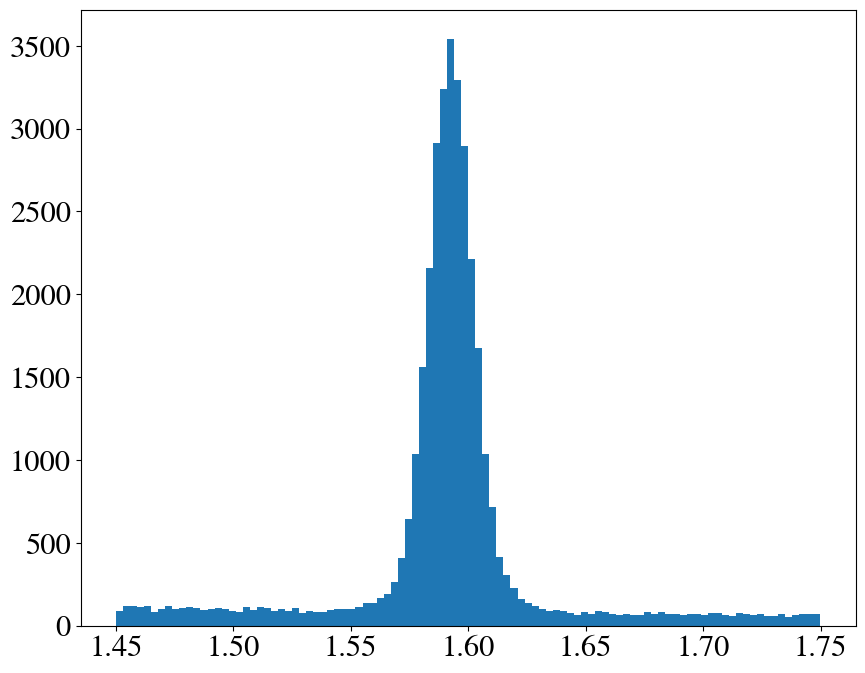

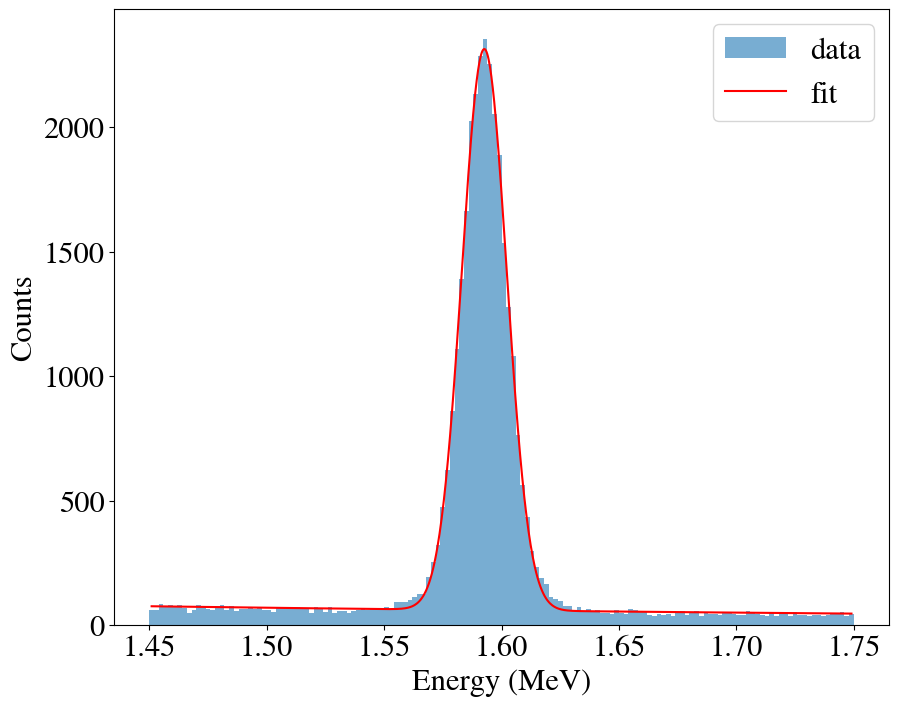

Signal events: 26898.301961360732
Background events: 9013.623757324964
Total Events by addition: 35911.9257186857
Total Events by row counting: 35906
FOM: [1.0, 1.0000047566266037, 1.000007308865403, 0.9999430878487394, 0.999854860577427, 1.0004918219410779, 1.0032300283959155, 1.0093913252418085, 1.0237837143583144, 1.051549311568224, 1.09951068396915, 1.1675588903239131, 1.2436751194446318, 1.3311597618344269, 1.408961816344627, 1.4901611948599833, 1.565987498465873, 1.6386541128592285, 1.7021137574023157, 1.7651587887816091, 1.8130705056957424, 1.861055555349113]
fom_err: [0.00845265951237657, 0.008452732556368497, 0.008453077954256894, 0.008453590692284142, 0.008454642361243462, 0.008462551915633545, 0.008489109581733318, 0.0085472494631556, 0.008682081978903838, 0.008943647264651662, 0.009397713239436131, 0.010053302769983988, 0.010808658538013332, 0.01169828459901837, 0.012538941674250735, 0.013439179543636468, 0.014325101087555615, 0.015225469290095401, 0.01607973090385951, 0.01

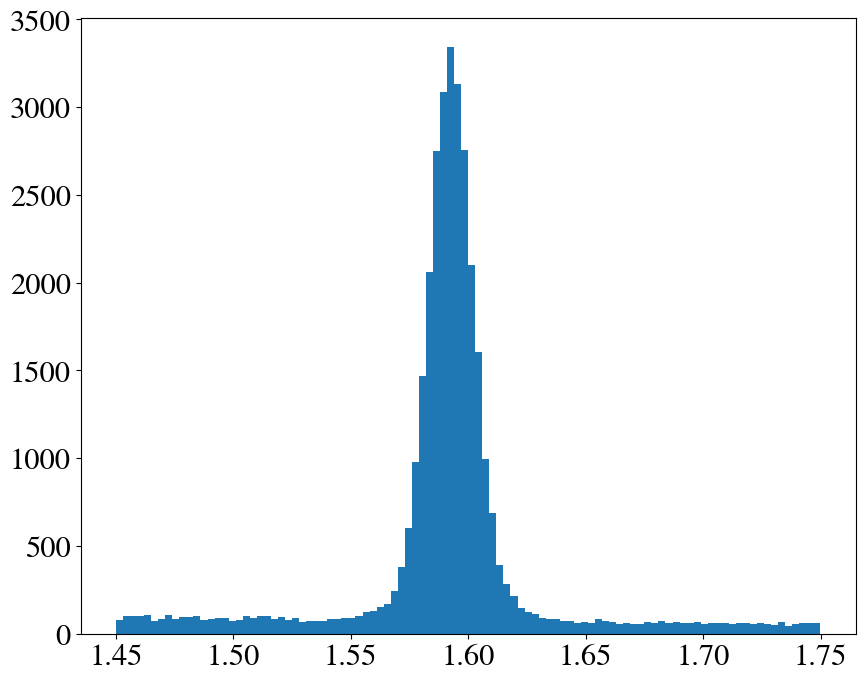

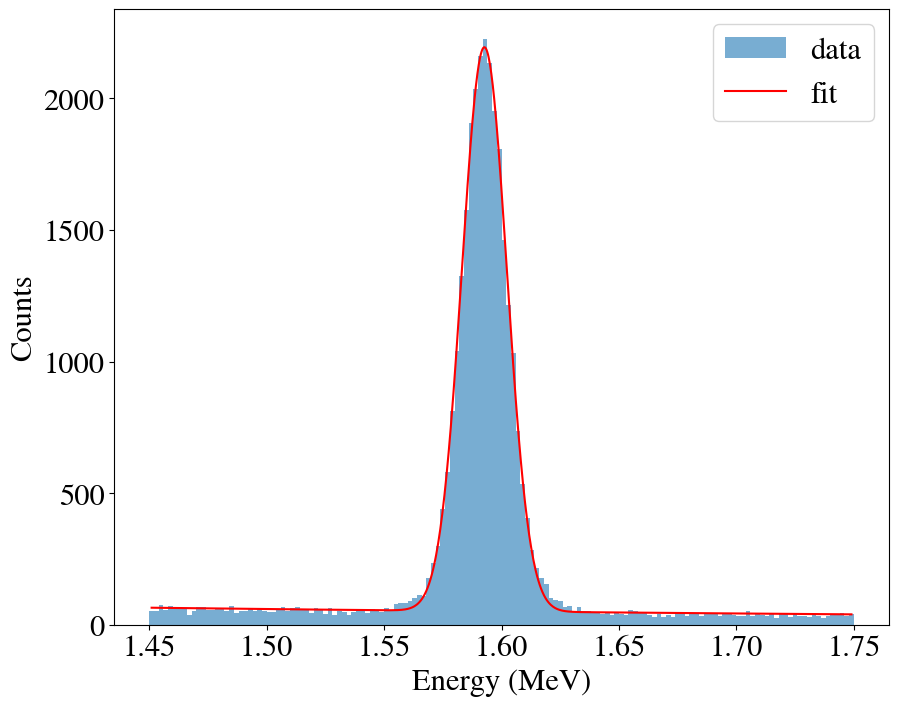

Signal events: 25633.15419133743
Background events: 7914.161708061468
Total Events by addition: 33547.3158993989
Total Events by row counting: 33542
FOM: [1.0, 1.0000047566266037, 1.000007308865403, 0.9999430878487394, 0.999854860577427, 1.0004918219410779, 1.0032300283959155, 1.0093913252418085, 1.0237837143583144, 1.051549311568224, 1.09951068396915, 1.1675588903239131, 1.2436751194446318, 1.3311597618344269, 1.408961816344627, 1.4901611948599833, 1.565987498465873, 1.6386541128592285, 1.7021137574023157, 1.7651587887816091, 1.8130705056957424, 1.861055555349113, 1.892708689565406]
fom_err: [0.00845265951237657, 0.008452732556368497, 0.008453077954256894, 0.008453590692284142, 0.008454642361243462, 0.008462551915633545, 0.008489109581733318, 0.0085472494631556, 0.008682081978903838, 0.008943647264651662, 0.009397713239436131, 0.010053302769983988, 0.010808658538013332, 0.01169828459901837, 0.012538941674250735, 0.013439179543636468, 0.014325101087555615, 0.015225469290095401, 0.01607

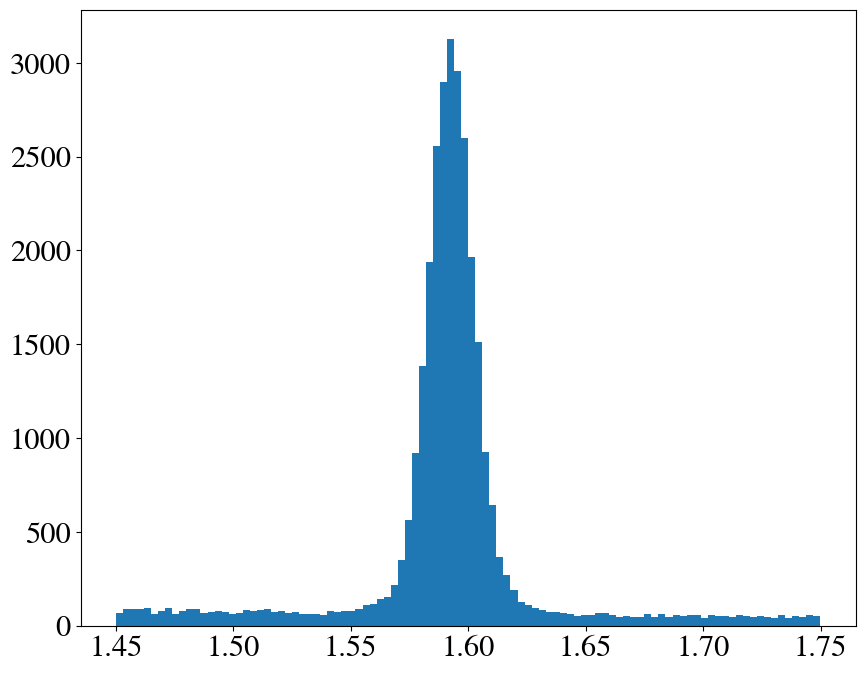

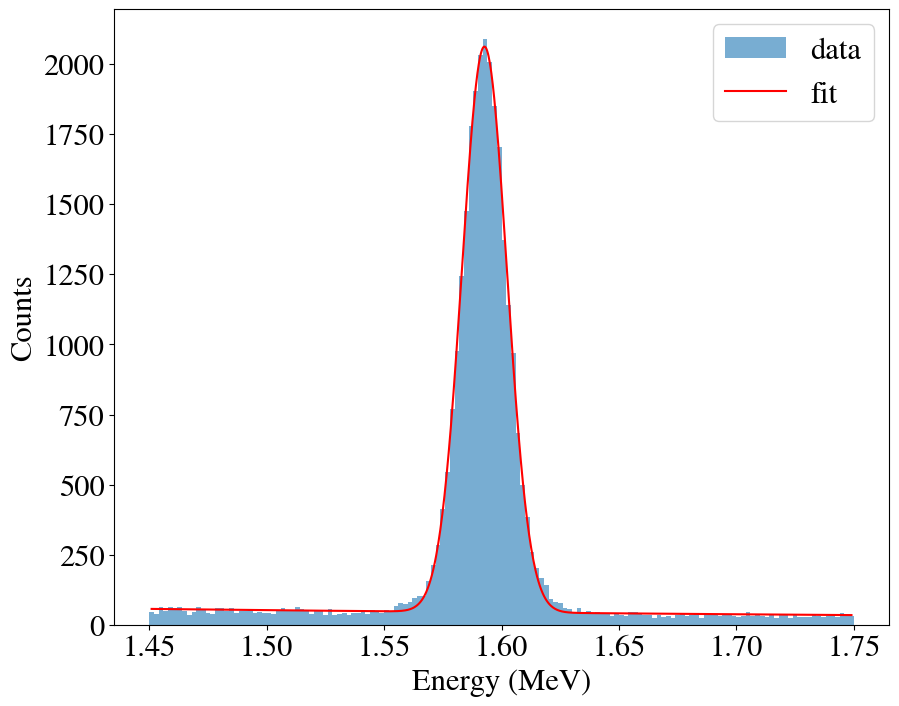

Signal events: 24128.72304428555
Background events: 6919.021177268131
Total Events by addition: 31047.744221553683
Total Events by row counting: 31043
FOM: [1.0, 1.0000047566266037, 1.000007308865403, 0.9999430878487394, 0.999854860577427, 1.0004918219410779, 1.0032300283959155, 1.0093913252418085, 1.0237837143583144, 1.051549311568224, 1.09951068396915, 1.1675588903239131, 1.2436751194446318, 1.3311597618344269, 1.408961816344627, 1.4901611948599833, 1.565987498465873, 1.6386541128592285, 1.7021137574023157, 1.7651587887816091, 1.8130705056957424, 1.861055555349113, 1.892708689565406, 1.9054440217314326]
fom_err: [0.00845265951237657, 0.008452732556368497, 0.008453077954256894, 0.008453590692284142, 0.008454642361243462, 0.008462551915633545, 0.008489109581733318, 0.0085472494631556, 0.008682081978903838, 0.008943647264651662, 0.009397713239436131, 0.010053302769983988, 0.010808658538013332, 0.01169828459901837, 0.012538941674250735, 0.013439179543636468, 0.014325101087555615, 0.01522

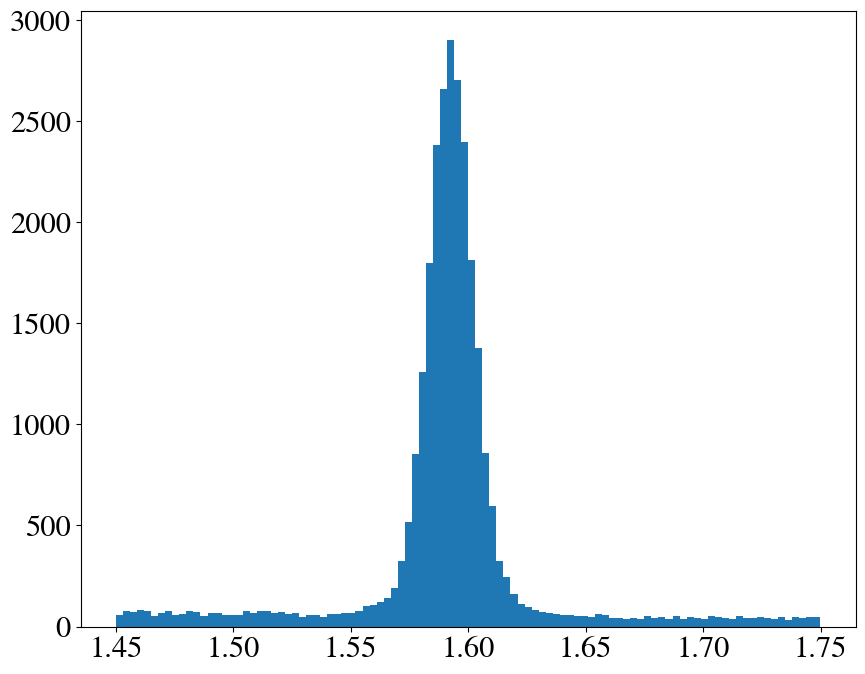

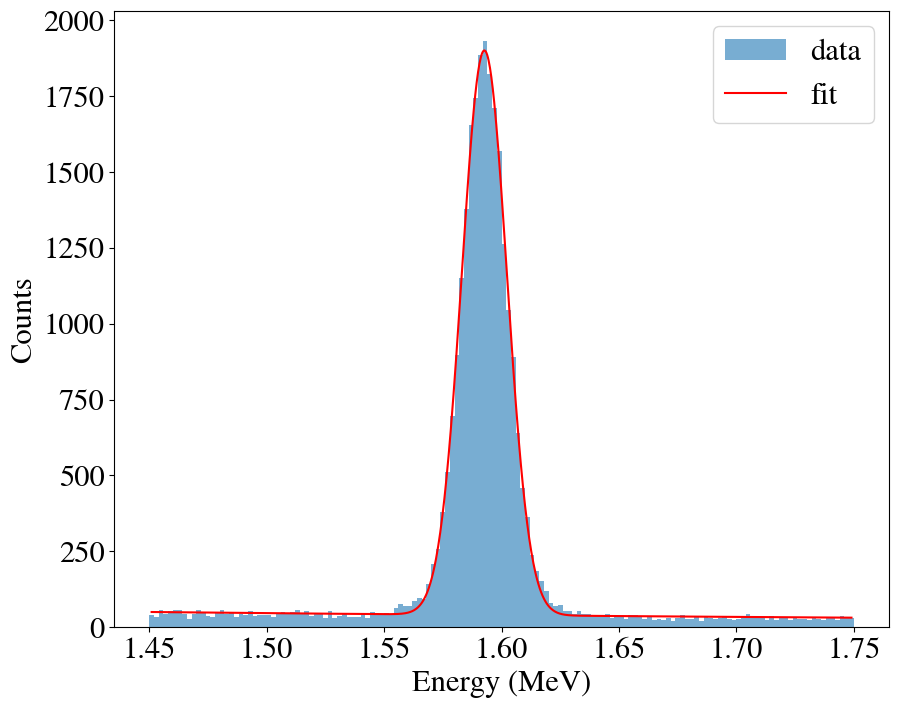

Signal events: 22312.528233049146
Background events: 5999.709136302711
Total Events by addition: 28312.237369351857
Total Events by row counting: 28308
FOM: [1.0, 1.0000047566266037, 1.000007308865403, 0.9999430878487394, 0.999854860577427, 1.0004918219410779, 1.0032300283959155, 1.0093913252418085, 1.0237837143583144, 1.051549311568224, 1.09951068396915, 1.1675588903239131, 1.2436751194446318, 1.3311597618344269, 1.408961816344627, 1.4901611948599833, 1.565987498465873, 1.6386541128592285, 1.7021137574023157, 1.7651587887816091, 1.8130705056957424, 1.861055555349113, 1.892708689565406, 1.9054440217314326, 1.8922036276051515]
fom_err: [0.00845265951237657, 0.008452732556368497, 0.008453077954256894, 0.008453590692284142, 0.008454642361243462, 0.008462551915633545, 0.008489109581733318, 0.0085472494631556, 0.008682081978903838, 0.008943647264651662, 0.009397713239436131, 0.010053302769983988, 0.010808658538013332, 0.01169828459901837, 0.012538941674250735, 0.013439179543636468, 0.014325

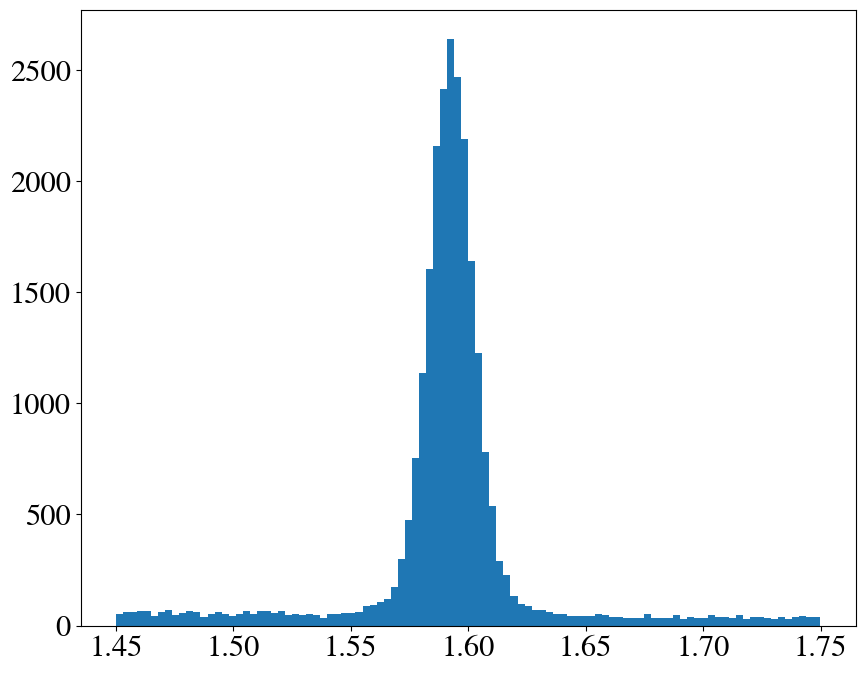

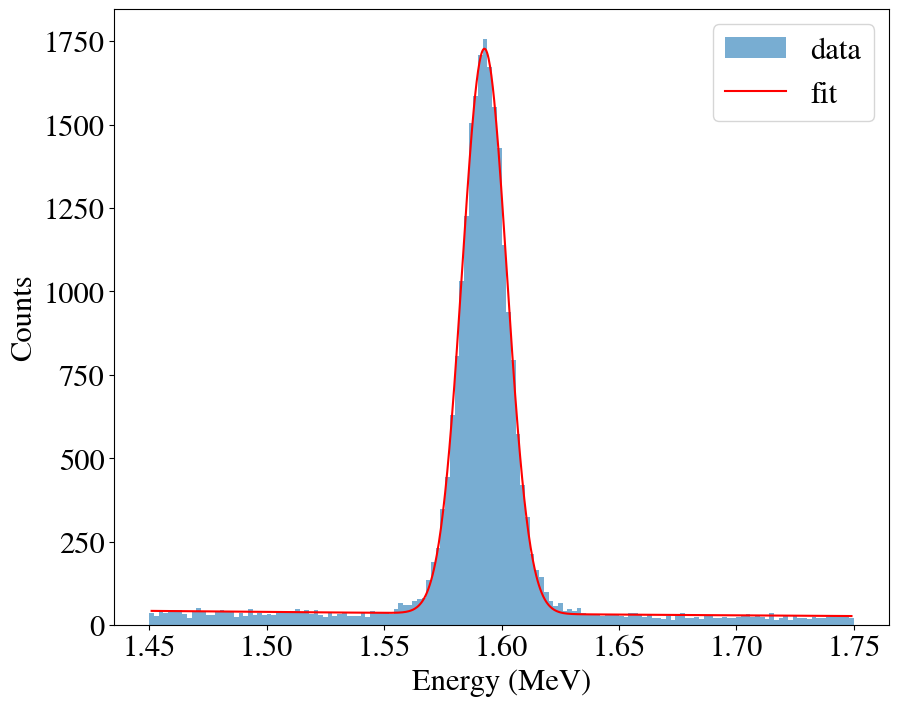

Signal events: 20187.181775126057
Background events: 5187.653964890086
Total Events by addition: 25374.835740016144
Total Events by row counting: 25371
FOM: [1.0, 1.0000047566266037, 1.000007308865403, 0.9999430878487394, 0.999854860577427, 1.0004918219410779, 1.0032300283959155, 1.0093913252418085, 1.0237837143583144, 1.051549311568224, 1.09951068396915, 1.1675588903239131, 1.2436751194446318, 1.3311597618344269, 1.408961816344627, 1.4901611948599833, 1.565987498465873, 1.6386541128592285, 1.7021137574023157, 1.7651587887816091, 1.8130705056957424, 1.861055555349113, 1.892708689565406, 1.9054440217314326, 1.8922036276051515, 1.841087290360953]
fom_err: [0.00845265951237657, 0.008452732556368497, 0.008453077954256894, 0.008453590692284142, 0.008454642361243462, 0.008462551915633545, 0.008489109581733318, 0.0085472494631556, 0.008682081978903838, 0.008943647264651662, 0.009397713239436131, 0.010053302769983988, 0.010808658538013332, 0.01169828459901837, 0.012538941674250735, 0.013439179

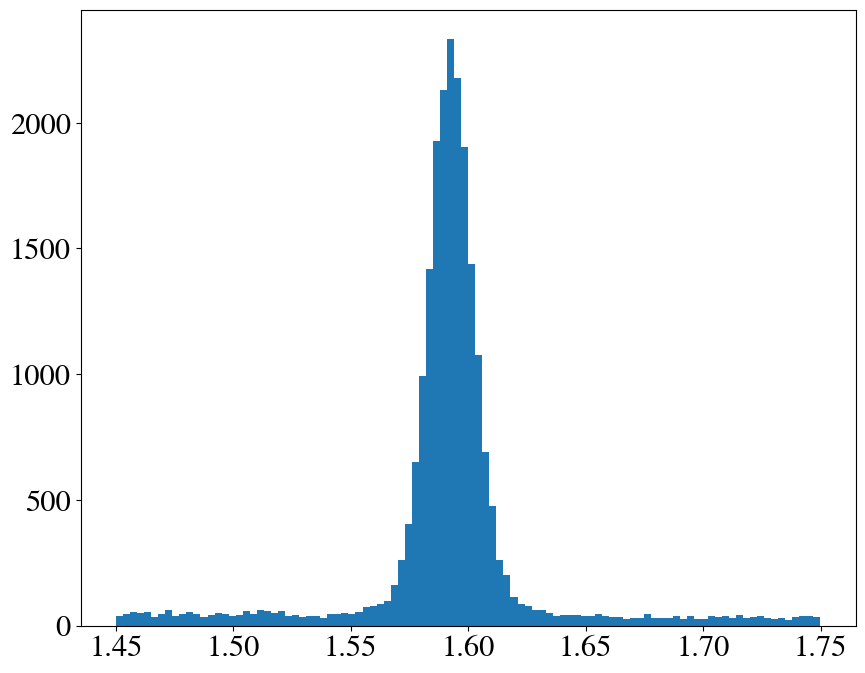

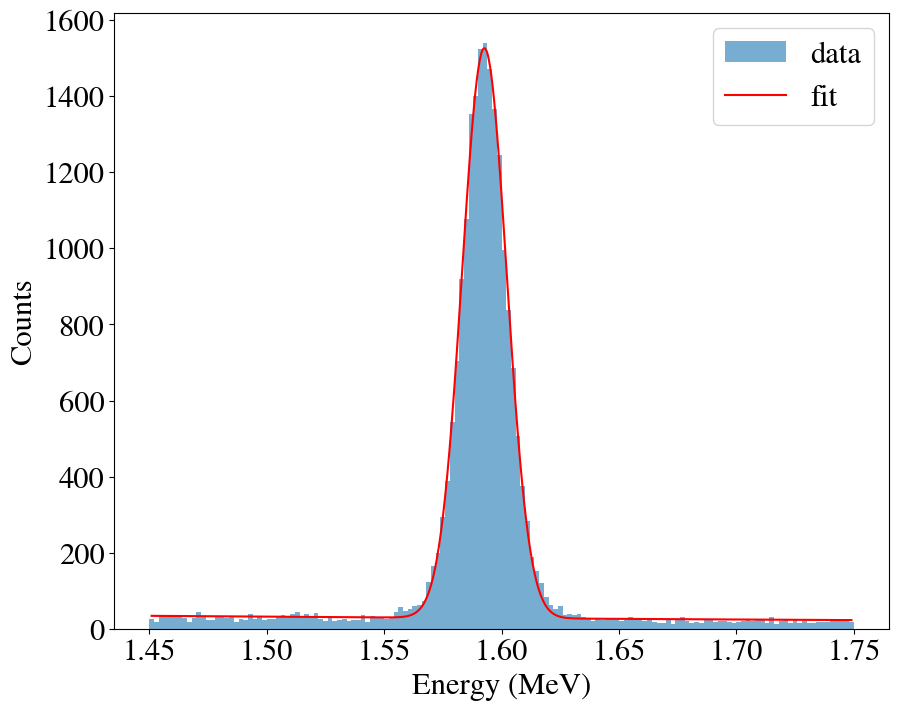

Signal events: 17796.592813095125
Background events: 4370.003224495299
Total Events by addition: 22166.596037590425
Total Events by row counting: 22164
FOM: [1.0, 1.0000047566266037, 1.000007308865403, 0.9999430878487394, 0.999854860577427, 1.0004918219410779, 1.0032300283959155, 1.0093913252418085, 1.0237837143583144, 1.051549311568224, 1.09951068396915, 1.1675588903239131, 1.2436751194446318, 1.3311597618344269, 1.408961816344627, 1.4901611948599833, 1.565987498465873, 1.6386541128592285, 1.7021137574023157, 1.7651587887816091, 1.8130705056957424, 1.861055555349113, 1.892708689565406, 1.9054440217314326, 1.8922036276051515, 1.841087290360953, 1.7683986355810506]
fom_err: [0.00845265951237657, 0.008452732556368497, 0.008453077954256894, 0.008453590692284142, 0.008454642361243462, 0.008462551915633545, 0.008489109581733318, 0.0085472494631556, 0.008682081978903838, 0.008943647264651662, 0.009397713239436131, 0.010053302769983988, 0.010808658538013332, 0.01169828459901837, 0.01253894167

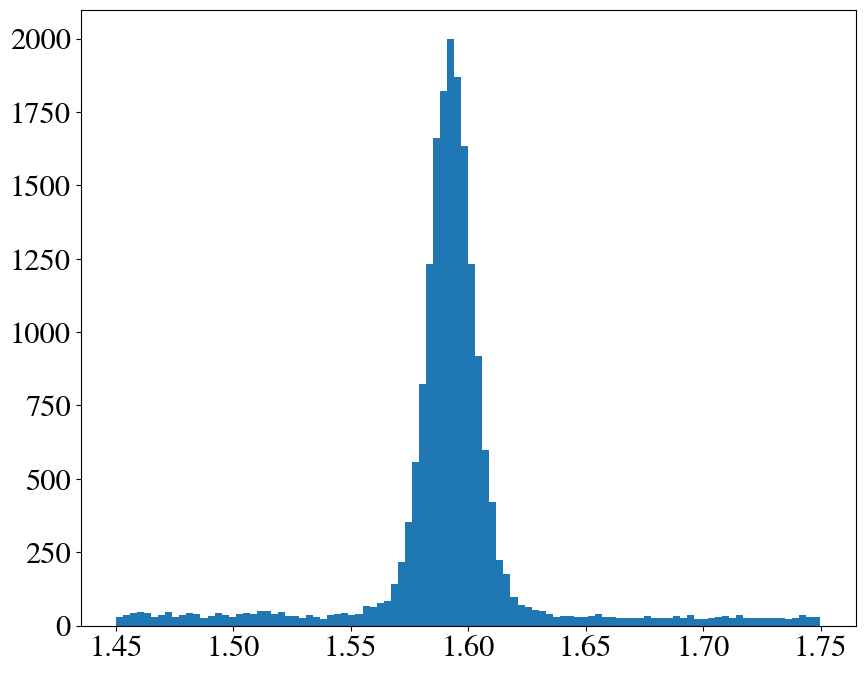

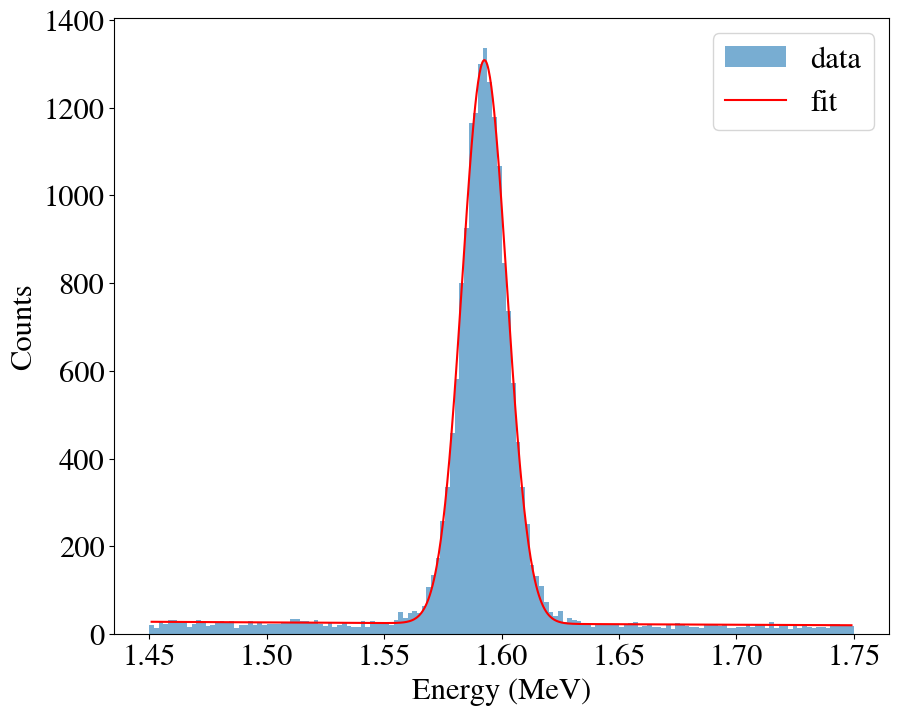

Signal events: 15290.663337399565
Background events: 3618.9339621863433
Total Events by addition: 18909.59729958591
Total Events by row counting: 18908
FOM: [1.0, 1.0000047566266037, 1.000007308865403, 0.9999430878487394, 0.999854860577427, 1.0004918219410779, 1.0032300283959155, 1.0093913252418085, 1.0237837143583144, 1.051549311568224, 1.09951068396915, 1.1675588903239131, 1.2436751194446318, 1.3311597618344269, 1.408961816344627, 1.4901611948599833, 1.565987498465873, 1.6386541128592285, 1.7021137574023157, 1.7651587887816091, 1.8130705056957424, 1.861055555349113, 1.892708689565406, 1.9054440217314326, 1.8922036276051515, 1.841087290360953, 1.7683986355810506, 1.6696297833245541]
fom_err: [0.00845265951237657, 0.008452732556368497, 0.008453077954256894, 0.008453590692284142, 0.008454642361243462, 0.008462551915633545, 0.008489109581733318, 0.0085472494631556, 0.008682081978903838, 0.008943647264651662, 0.009397713239436131, 0.010053302769983988, 0.010808658538013332, 0.011698284599

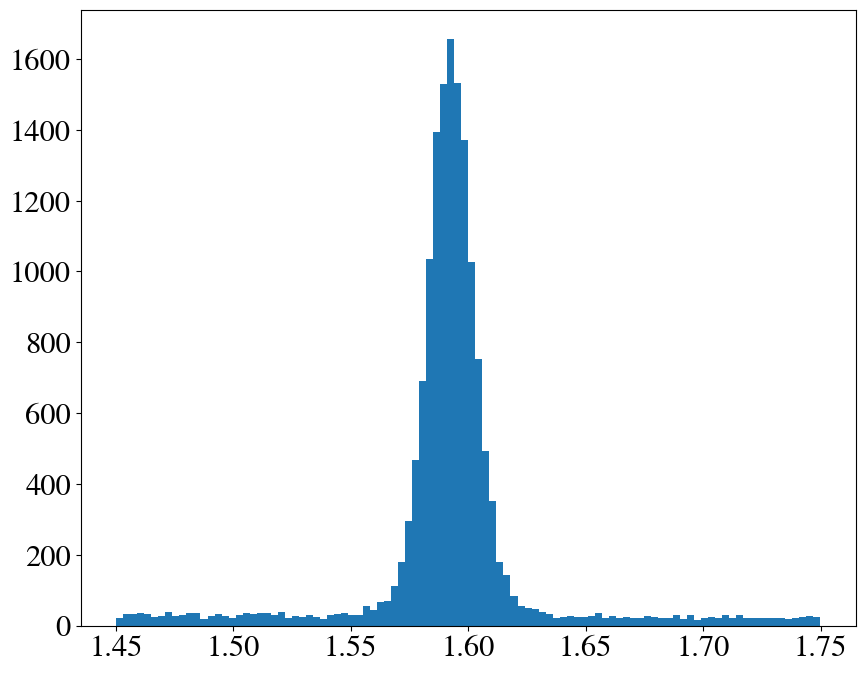

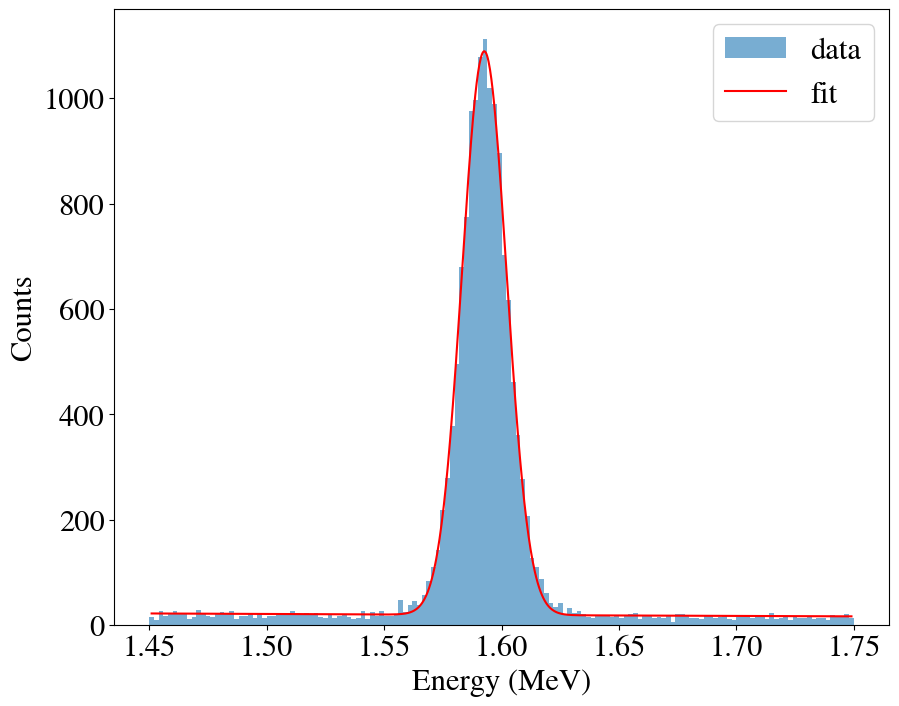

Signal events: 12748.08019075511
Background events: 2908.8416755866274
Total Events by addition: 15656.921866341738
Total Events by row counting: 15656
FOM: [1.0, 1.0000047566266037, 1.000007308865403, 0.9999430878487394, 0.999854860577427, 1.0004918219410779, 1.0032300283959155, 1.0093913252418085, 1.0237837143583144, 1.051549311568224, 1.09951068396915, 1.1675588903239131, 1.2436751194446318, 1.3311597618344269, 1.408961816344627, 1.4901611948599833, 1.565987498465873, 1.6386541128592285, 1.7021137574023157, 1.7651587887816091, 1.8130705056957424, 1.861055555349113, 1.892708689565406, 1.9054440217314326, 1.8922036276051515, 1.841087290360953, 1.7683986355810506, 1.6696297833245541, 1.5526334228203895]
fom_err: [0.00845265951237657, 0.008452732556368497, 0.008453077954256894, 0.008453590692284142, 0.008454642361243462, 0.008462551915633545, 0.008489109581733318, 0.0085472494631556, 0.008682081978903838, 0.008943647264651662, 0.009397713239436131, 0.010053302769983988, 0.01080865853801

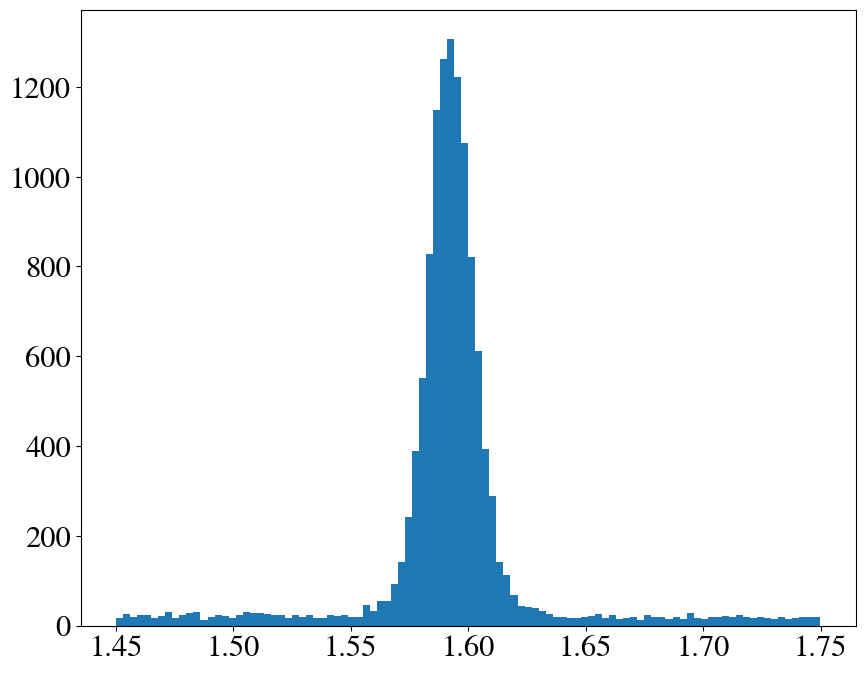

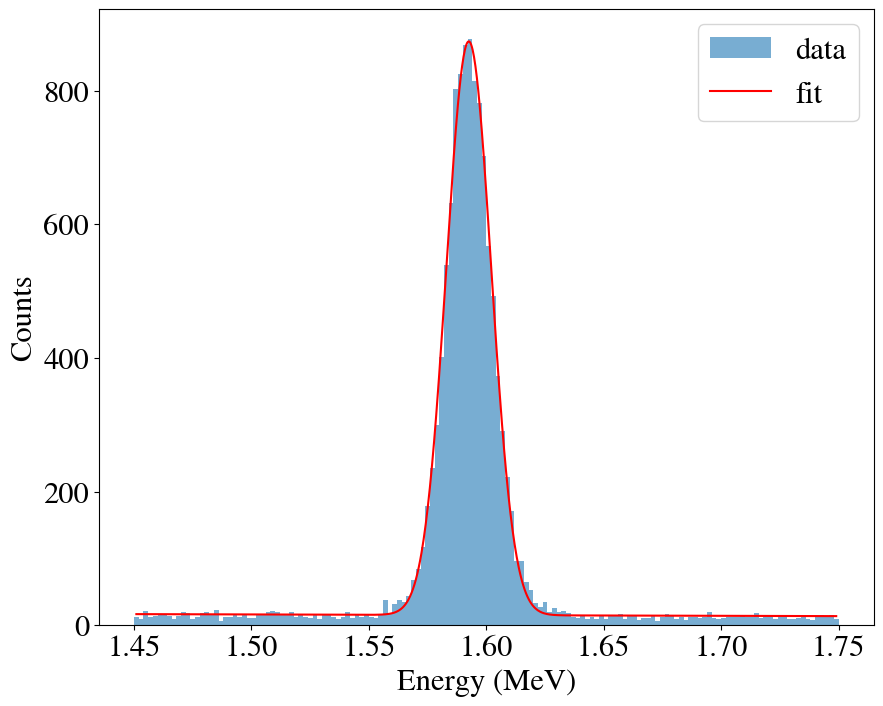

Signal events: 10273.717937216403
Background events: 2252.645443602107
Total Events by addition: 12526.36338081851
Total Events by row counting: 12526
FOM: [1.0, 1.0000047566266037, 1.000007308865403, 0.9999430878487394, 0.999854860577427, 1.0004918219410779, 1.0032300283959155, 1.0093913252418085, 1.0237837143583144, 1.051549311568224, 1.09951068396915, 1.1675588903239131, 1.2436751194446318, 1.3311597618344269, 1.408961816344627, 1.4901611948599833, 1.565987498465873, 1.6386541128592285, 1.7021137574023157, 1.7651587887816091, 1.8130705056957424, 1.861055555349113, 1.892708689565406, 1.9054440217314326, 1.8922036276051515, 1.841087290360953, 1.7683986355810506, 1.6696297833245541, 1.5526334228203895, 1.4218880475530102]
fom_err: [0.00845265951237657, 0.008452732556368497, 0.008453077954256894, 0.008453590692284142, 0.008454642361243462, 0.008462551915633545, 0.008489109581733318, 0.0085472494631556, 0.008682081978903838, 0.008943647264651662, 0.009397713239436131, 0.01005330276998398

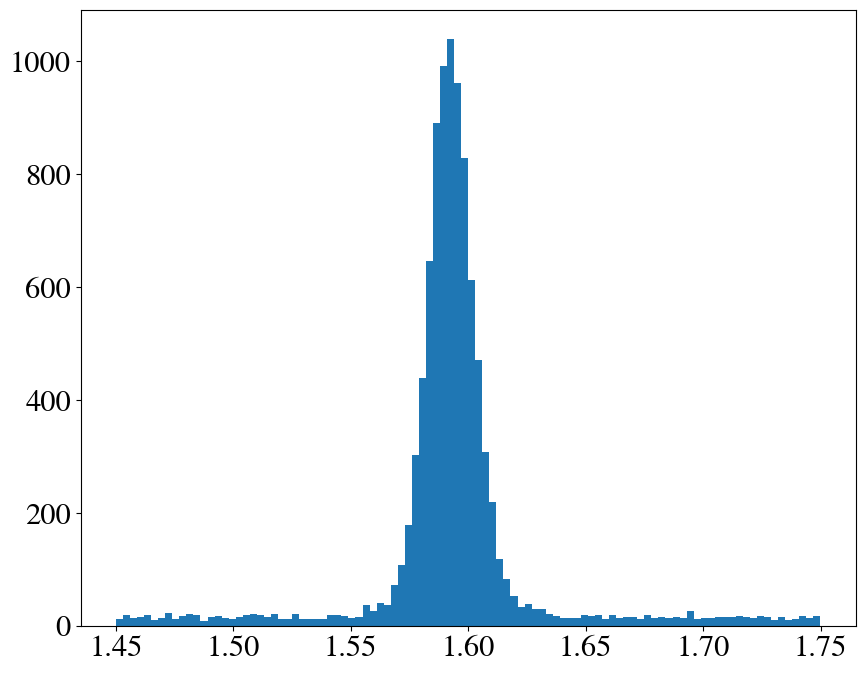

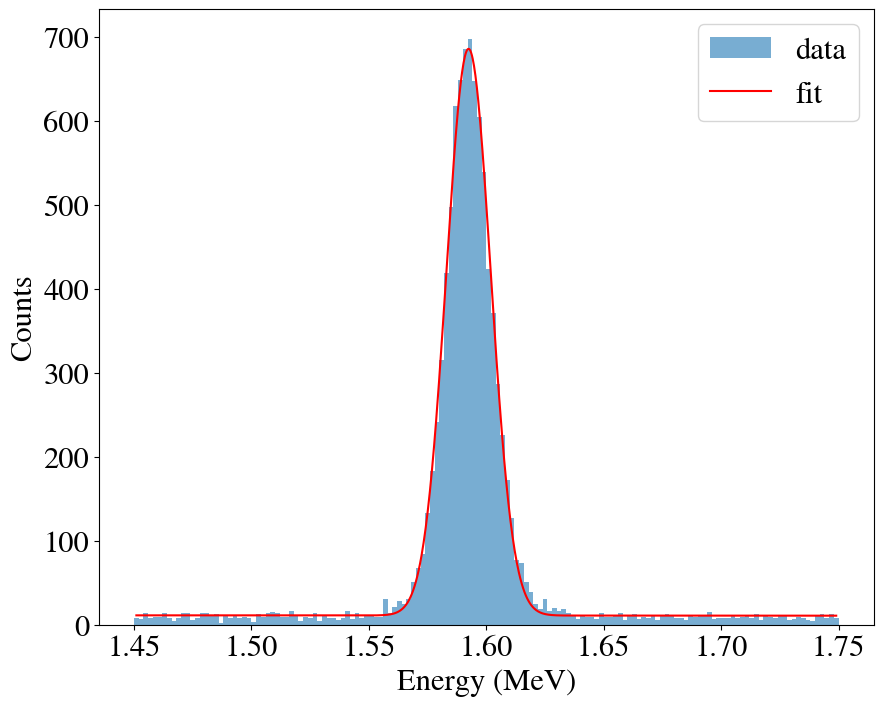

Signal events: 7978.42192741804
Background events: 1727.589124604076
Total Events by addition: 9706.011052022115
Total Events by row counting: 9706
FOM: [1.0, 1.0000047566266037, 1.000007308865403, 0.9999430878487394, 0.999854860577427, 1.0004918219410779, 1.0032300283959155, 1.0093913252418085, 1.0237837143583144, 1.051549311568224, 1.09951068396915, 1.1675588903239131, 1.2436751194446318, 1.3311597618344269, 1.408961816344627, 1.4901611948599833, 1.565987498465873, 1.6386541128592285, 1.7021137574023157, 1.7651587887816091, 1.8130705056957424, 1.861055555349113, 1.892708689565406, 1.9054440217314326, 1.8922036276051515, 1.841087290360953, 1.7683986355810506, 1.6696297833245541, 1.5526334228203895, 1.4218880475530102, 1.2609009005055856]
fom_err: [0.00845265951237657, 0.008452732556368497, 0.008453077954256894, 0.008453590692284142, 0.008454642361243462, 0.008462551915633545, 0.008489109581733318, 0.0085472494631556, 0.008682081978903838, 0.008943647264651662, 0.009397713239436131, 0.

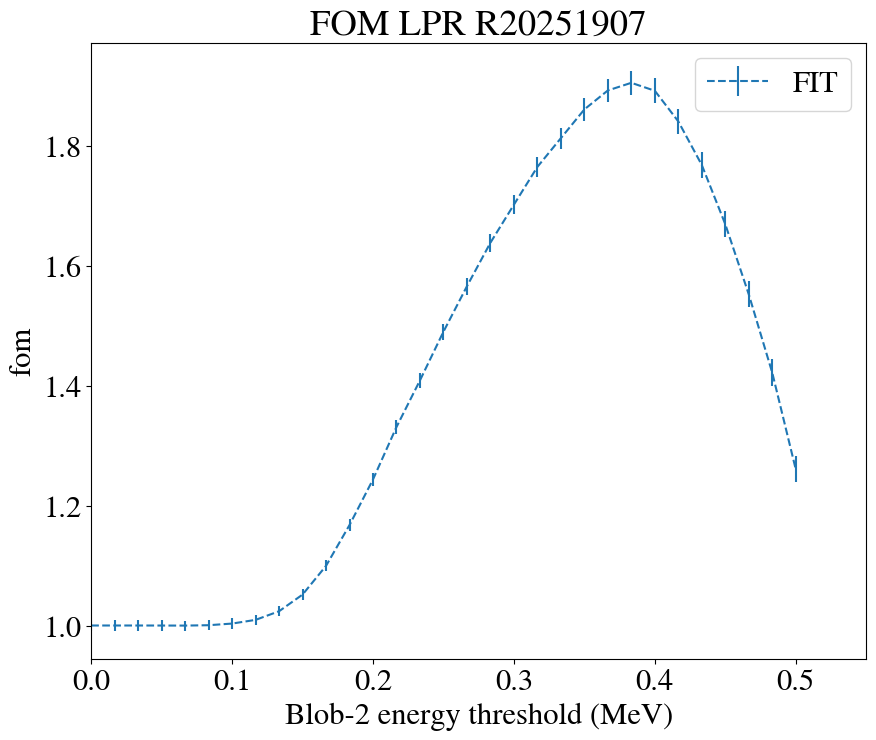

In [7]:
RUN_NUMBER = '15589, 15590, 15591, 15592, 15593, 15594, 15596'
RUN_NUMBER = [int(x) for x in RUN_NUMBER.split(',')]
TIMESTAMP  = '110725, 120725, 130725, 140725, 150725, 160725, 170725'
TIMESTAMP  = [int(x) for x in TIMESTAMP.split(',')]
CITY       = 'thekla'
FOM_TS     = '20251907'
    

main(RUN_NUMBER, TIMESTAMP, CITY, FOM_TS)